In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import os
import matplotlib.pyplot as plt
from itertools import compress
import calfews_src
# from read_hdf5_output import get_results_sensitivity_number
from calfews_src import *
from calfews_src.visualizer import Visualizer
from calfews_src.util import *
import seaborn as sns
import importlib
import make_financial_data_km
from make_financial_data_km import analyze_correlation_between_pumping_and_revenue
from make_financial_data_km import analyze_correlation_between_pumping_and_revenue_historical
from make_financial_data_km import analyze_correlation_between_total_revenue_and_pumping
import matplotlib.gridspec as gridspec
import seaborn as sns
importlib.reload(make_financial_data_km)

from calfews_src.strategy_compare import plot_water_purchase_costs
# importlib.reload(strategy_compare)
importlib.reload(make_financial_data_km)
importlib.reload(calfews_src.strategy_compare)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


# Basis risk examination

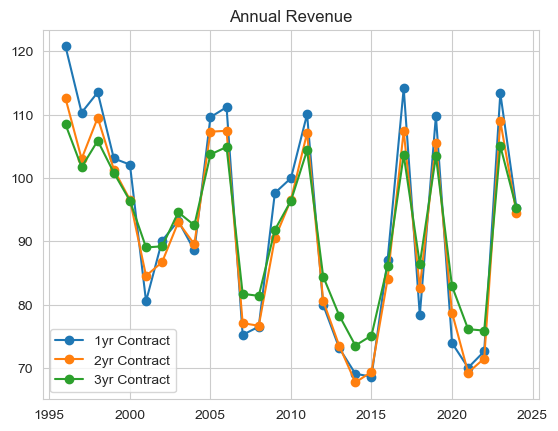

In [2]:
# revenue_3y = pd.read_csv('plots/pumping_vs_revenue_KCWA_3yr.csv')
revenue_3y = pd.read_csv('plots/pumping_vs_revenue_KCWA_30years_longleaf.csv')
revenue_3y['GroupNumber'] = None
counters = {}

for index, row in revenue_3y.iterrows():
    year = row['Year']
    simulation = row['Simulation']
    key = (year, simulation)

    if key not in counters:
        counters[key] = 1
    else:
        counters[key] += 1

    revenue_3y.at[index, 'GroupNumber'] = counters[key]

group_sorted = revenue_3y.sort_values(by=['Year', 'Simulation', 'GroupNumber'])

average_revenue_3y = revenue_3y.groupby(['Year','GroupNumber'])['Total Annual Revenue'].mean()
average_revenue_3y = average_revenue_3y.reset_index()
filtered_1y = average_revenue_3y[average_revenue_3y['GroupNumber'] == 1]
filtered_2y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2)]
filtered_2y = filtered_2y.groupby(['Year']).mean().reset_index()
filtered_3y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2) | (average_revenue_3y['GroupNumber'] == 3)]
filtered_3y = filtered_3y.groupby(['Year']).mean().reset_index()
plt.plot(filtered_1y['Year'], filtered_1y['Total Annual Revenue'], label = '1yr Contract', marker='o')
plt.plot(filtered_2y['Year'], filtered_2y['Total Annual Revenue'], label = '2yr Contract', marker='o')
plt.plot(filtered_3y['Year'], filtered_3y['Total Annual Revenue'], label = '3yr Contract', marker='o')
plt.legend()
plt.title('Annual Revenue')
plt.show()

In [ ]:
# group_sorted.to_csv('plots/pumping_vs_revenue_KCWA_3yr.csv', index=False, columns=['Year', 'Simulation', 'Total Pumping', 'Total Annual Revenue', 'GroupNumber'])
# group_sorted.to_csv('plots/pumping_vs_revenue_KCWA_30years_longleaf.csv', index=False, columns=['Year', 'Simulation', 'Total Pumping', 'Total Annual Revenue', 'GroupNumber'])


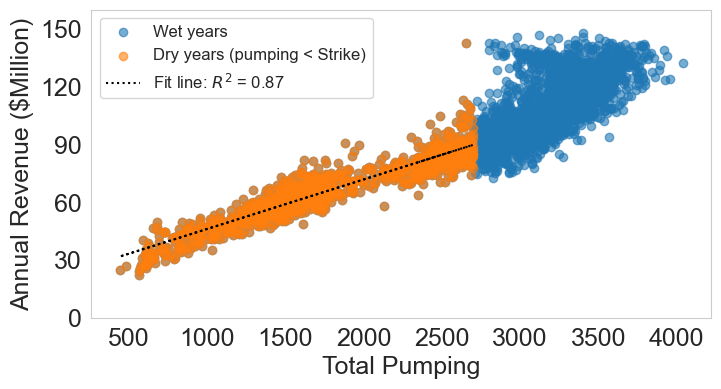

In [3]:
#######################basis risk for 2-year synthetic data#######################
###################### kern county water agency ##################################

fig, ax = plt.subplots(figsize=(8, 4))
read_file = 'plots/pumping_vs_revenue_KCWA_3yr.csv'
read_file= pd.read_csv(read_file, index_col=0, parse_dates=True)
revenue_3y['GroupNumber'] = None
counters = {}

for index, row in revenue_3y.iterrows():
    year = row['Year']
    simulation = row['Simulation']
    key = (year, simulation)
    if key not in counters:
        counters[key] = 1
    else:
        counters[key] += 1

    revenue_3y.at[index, 'GroupNumber'] = counters[key]

group_sorted = revenue_3y.sort_values(by=['Year', 'Simulation', 'GroupNumber'])

group_sorted_2yr = group_sorted[group_sorted['GroupNumber'] == 1]
y = group_sorted_2yr['Total Annual Revenue']
x = group_sorted_2yr['Total Pumping']

x_threshold = 2700

filtered_data = group_sorted_2yr[group_sorted_2yr['Total Pumping'] < x_threshold]
x_filtered = filtered_data['Total Pumping']
y_filtered = filtered_data['Total Annual Revenue']

ax.scatter(x, y, alpha=0.6, label='Wet years ')
ax.scatter(x_filtered, y_filtered, alpha=0.6, label='Dry years (pumping < Strike)')

slope_kcwa, intercept = np.polyfit(x_filtered, y_filtered, 1)
line = slope_kcwa * x_filtered + intercept  # Line equation for filtered data
corr_coef = np.corrcoef(x_filtered, y_filtered)[0, 1]
r_squared = corr_coef ** 2
plt.plot(x_filtered, line, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared:.2f}')


corr_coef = np.corrcoef(x_filtered, y_filtered)[0, 1]

ax.set_xlabel("Total Pumping",  fontsize=18)
ax.set_ylabel("Annual Revenue ($Million)",  fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid(False)
ax.legend(fontsize=12)
ax.set_ylim(0, 160)
plt.yticks(np.arange(0,160,30))

# ax.set_xlim(500, 4400)
# plt.savefig('plots/pumping_vs_revenue_KCWA_2yr.png')
plt.show()


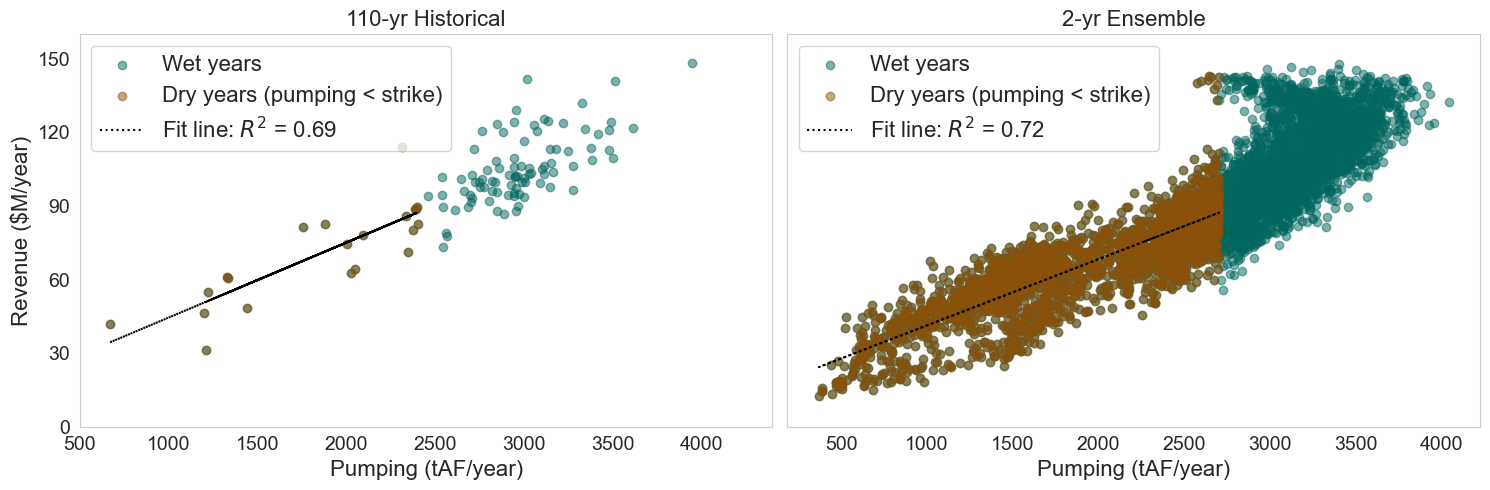

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------- First Plot: 110-year Historical Data ------------
revenue_file = 'plots/pumping_vs_revenue_KCWA_110yr.csv'
Yearly_revenue = pd.read_csv(revenue_file)

x_threshold = 2704 * 0.9
filtered_data_110 = Yearly_revenue[Yearly_revenue['Total Pumping'] < x_threshold]
x_110 = filtered_data_110['Total Pumping']
y_110 = filtered_data_110['Annual Revenue']

slope_110, intercept_110 = np.polyfit(x_110, y_110, 1)
line_110 = slope_110 * x_110 + intercept_110
r_squared_110 = np.corrcoef(x_110, y_110)[0, 1] ** 2

# ----------- Second Plot: 2-year Synthetic Data ------------
read_file = 'plots/pumping_vs_revenue_KCWA_30years_longleaf.csv'
revenue_3y = pd.read_csv(read_file, index_col=0, parse_dates=True)

# revenue_3y['GroupNumber'] = revenue_3y.groupby(['Year', 'Simulation']).cumcount() + 1
# group_sorted_2yr = revenue_3y[revenue_3y['GroupNumber'] == 1]
group_sorted_2yr = revenue_3y[revenue_3y['GroupNumber'].isin([1, 2])]

x_2yr = group_sorted_2yr['Total Pumping']
y_2yr = group_sorted_2yr['Total Annual Revenue']
x_threshold_2yr = 2704 

filtered_2yr = group_sorted_2yr[x_2yr < x_threshold_2yr]
x_2yr_filt = filtered_2yr['Total Pumping']
y_2yr_filt = filtered_2yr['Total Annual Revenue']

slope_2yr, intercept_2yr = np.polyfit(x_2yr_filt, y_2yr_filt, 1)
line_2yr = slope_2yr * x_2yr_filt + intercept_2yr
r_squared_2yr = np.corrcoef(x_2yr_filt, y_2yr_filt)[0, 1] ** 2

# ----------- Combined Plot ------------
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# --- Left subplot: 110-year ---
axs[0].scatter(Yearly_revenue['Total Pumping'], Yearly_revenue['Annual Revenue'], color = '#01665e', alpha=0.5, label='Wet years')
axs[0].scatter(x_110, y_110, color= '#8c510a',  alpha=0.5, label='Dry years (pumping < strike)')
axs[0].plot(x_110, line_110, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared_110:.2f}')
axs[0].set_xlabel("Pumping (tAF/year)", fontsize=16)
axs[0].set_ylabel("Revenue ($M/year)", fontsize=16)
axs[0].set_xlim(500, 4400)
axs[0].set_ylim(50, 160)
axs[0].set_yticks(np.arange(0, 160, 30))
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=16, loc = 'upper left')
axs[0].set_title("110-yr Historical", fontsize=16)
axs[0].grid(False)

# --- Right subplot: 2-year synthetic ---
axs[1].scatter(x_2yr, y_2yr,color = '#01665e',  alpha=0.5, label='Wet years')
axs[1].scatter(x_2yr_filt, y_2yr_filt, color= '#8c510a', alpha=0.5, label='Dry years (pumping < strike)')
axs[1].plot(x_2yr_filt, line_2yr, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared_2yr:.2f}')
axs[1].set_xlabel("Pumping (tAF/year)", fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=16, loc = 'upper left')
axs[1].set_title("2-yr Ensemble", fontsize=16)
axs[1].grid(False)

plt.tight_layout()
# plt.savefig("Figure/index_insurance/combined_basis_risk_KCWA.png", dpi=300)
plt.show()


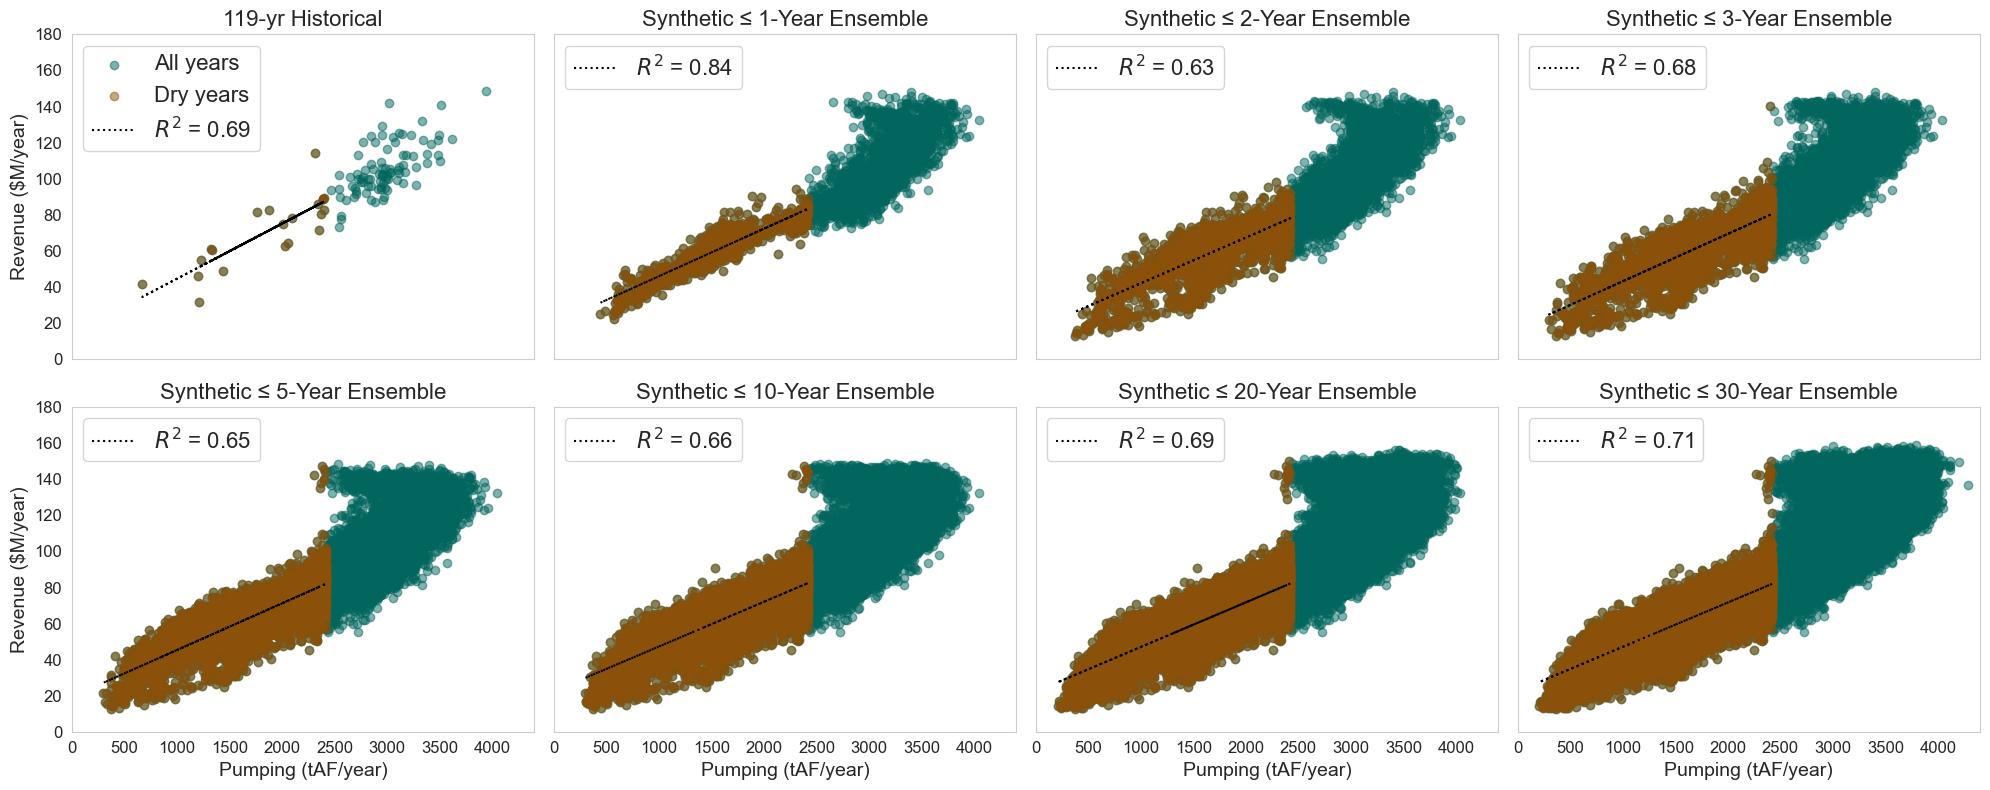

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical
hist_file = 'plots/pumping_vs_revenue_KCWA_110yr.csv'
hist = pd.read_csv(hist_file)
x_thresh = 2691 * 0.9

# Load synthetic
syn_file = 'plots/pumping_vs_revenue_KCWA_30years_longleaf.csv'
syn = pd.read_csv(syn_file, index_col=0, parse_dates=True)

# The ensemble sizes we'll show
ensemble_sizes = [1, 2, 3, 5, 10, 20, 30]

# Prepare figure
fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.ravel()

# --- Subplot 0: Historical data ---
ax = axs[0]
# scatter
ax.scatter(hist['Total Pumping'], hist['Annual Revenue'],
           color='#01665e', alpha=0.5, label='All years')
# highlight “dry” years
dry = hist['Total Pumping'] < x_thresh
ax.scatter(hist.loc[dry, 'Total Pumping'], hist.loc[dry, 'Annual Revenue'],
           color='#8c510a', alpha=0.5, label='Dry years')
# fit line
x_h = hist.loc[dry, 'Total Pumping']
y_h = hist.loc[dry, 'Annual Revenue']
m, b = np.polyfit(x_h, y_h, 1)
r2 = np.corrcoef(x_h, y_h)[0,1]**2
ax.plot(x_h, m*x_h + b, 'k:', label=f'$R^2$ = {r2:.2f}')
ax.set_title("119-yr Historical")
ax.legend(fontsize=16)
ax.grid(False)

# --- Subplots 1–7: Synthetic with increasing ensemble sizes ---
for i, n in enumerate(ensemble_sizes, start=1):
    ax = axs[i]
    # filter to first n sims
    df = syn[syn['GroupNumber'] <= n]
    # dry vs wet
    dry = df['Total Pumping'] < x_thresh
    ax.scatter(df['Total Pumping'], df['Total Annual Revenue'],
               color='#01665e', alpha=0.5)
    ax.scatter(df.loc[dry, 'Total Pumping'], df.loc[dry, 'Total Annual Revenue'],
               color='#8c510a', alpha=0.5)
    # fit
    x_d = df.loc[dry, 'Total Pumping']
    y_d = df.loc[dry, 'Total Annual Revenue']
    m, b = np.polyfit(x_d, y_d, 1)
    r2 = np.corrcoef(x_d, y_d)[0,1]**2
    ax.plot(x_d, m*x_d + b, 'k:', label=f'$R^2$ = {r2:.2f}')
    ax.set_title(f"Synthetic ≤ {n}-Year Ensemble")
    ax.legend(fontsize=16, loc= 'upper left')
    ax.grid(False)

# Common styling
for idx, ax in enumerate(axs):
    ax.set_xlim(0, 4400)
    ax.set_ylim(0, 180)
    # ax.set_xlabel("Pumping (tAF/year)", fontsize=14)
    ax.set_title(ax.get_title(), fontsize=16)
    ax.tick_params(labelsize=12)
    if idx >= 4:
        ax.set_xlabel("Pumping (tAF/year)", fontsize=14)

axs[0].set_ylabel("Revenue ($M/year)", fontsize=14)
axs[4].set_ylabel("Revenue ($M/year)", fontsize=14)
plt.tight_layout()
plt.show()


# figures for presentation

# Intial condition and net payout 

# payout and premium

In [5]:
import numpy as np
from scipy.stats import norm
import scipy.stats as st


def simple_wang_transform(payouts, lam= -0.25):
    """
    Apply a simplified Wang transform to an input tuple of payouts and return both
    the transformed payout (premium) and the net position (whole).

    :param payouts: A tuple of payout values.
    :param lam: Lambda parameter for the Wang transform (risk adjustment).
    :param from_user: Boolean flag for determining perspective (user's or insurer's).
    :return: A tuple containing the transformed payout (premium) and the whole.
    """
    payouts = pd.DataFrame(payouts, columns=['payout'])
    unique_pays = pd.DataFrame()
    unique_pays['unique'] = payouts.payout.unique()
    unique_pays['prob'] = 0 
    for j in range(len(unique_pays)):  
        count = 0
        val = unique_pays['unique'].iloc[j]
        for i in np.arange(len(payouts)): 
            if payouts['payout'].iloc[i] == val: 
                count += 1
        unique_pays['prob'].iloc[j] = count/len(payouts)
    unique_pays.sort_values(inplace=True, by='unique')
    dum = unique_pays['prob'].cumsum()  # asset cdf
    dum = st.norm.cdf(st.norm.ppf(dum) - 0.25)  # risk transformed payout cdf
    dum = np.append(dum[0], np.diff(dum))  # risk transformed asset pdf
    prem = (dum * unique_pays['unique']).sum()


    whole = payouts - prem

    return prem


In [152]:
df = pd.read_csv("plots/pumping_vs_revenue_KCWA_30years_longleaf.csv")

slope = slope_kcwa
mean_value = 2700
strike_90 = 0.9 * mean_value,
strike_70 = 0.7 * mean_value,
strike_50 = 0.5 * mean_value
strike_levels = {
    "90": 0.9 * mean_value,
    "70": 0.7 * mean_value,
    "50": 0.5 * mean_value
}

# Output: dictionaries of year → list of averaged premiums (length 30/15/10)
contract_lengths = [1, 2, 3, 5, 10, 20, 30]
premium_by_length = {length: [] for length in contract_lengths}
expectation_by_length = {length: [] for length in contract_lengths}
rev_by_length = {length: [] for length in contract_lengths}

for year, group_year in df.groupby("Year"):
    # if len(group_year["Simulation"].unique()) != 100:
    #     continue  # skip if incomplete

    group_year = group_year.sort_values(["Simulation", "GroupNumber"])
    
    pump_matrix = (
        group_year.pivot(index="Simulation", columns="GroupNumber", values="Total Pumping")
                  .sort_index(axis=1).fillna(0)
                  .to_numpy()
    )  # shape (100, 30)
    rev_matrix = (
        group_year.pivot(index="Simulation", columns="GroupNumber", values="Total Annual Revenue")
                  .sort_index(axis=1).fillna(0)
                  .to_numpy()
    )

    for k in contract_lengths:  # contract lengths
        n_blocks = 30 // k
        premiums_k_90, premiums_k_70, premiums_k_50 = [], [], []
        expects_k_90, expects_k_70, expects_k_50 = [], [], []   
        avg_revs = [] 

        for i in range(n_blocks):
            seg = pump_matrix[:, i * k:(i + 1) * k]  # shape (100, k)
            rev_seg = rev_matrix[:, i * k:(i + 1) * k] 

            avg_rev_block = np.mean(rev_seg, axis=1).mean() # average revenue for this block
            avg_revs.append(avg_rev_block)

            for strike_label, strike in strike_levels.items():
                payouts = slope * np.maximum(strike - seg, 0)  # shape (100, k)
                payouts_sum = np.sum(payouts, axis=1).reshape(100, 1)

                # expectation and premium
                expect = np.mean(payouts_sum)
                premium = simple_wang_transform(payouts_sum.flatten())

                if strike_label == "90":
                    premiums_k_90.append(premium)
                    expects_k_90.append(expect)
                elif strike_label == "70":
                    premiums_k_70.append(premium)
                    expects_k_70.append(expect)
                elif strike_label == "50":
                    premiums_k_50.append(premium)
                    expects_k_50.append(expect)

        premium_by_length[k].append((premiums_k_90, premiums_k_70, premiums_k_50))
        expectation_by_length[k].append((expects_k_90, expects_k_70, expects_k_50))
        rev_by_length[k].append(avg_revs)

years = list(range(1996, 2025))
records = []
for k in contract_lengths:
    for year_idx, year in enumerate(years):
        prem_90, prem_70, prem_50 = premium_by_length[k][year_idx]
        exp_90, exp_70, exp_50 = expectation_by_length[k][year_idx]
        avg_revs = rev_by_length[k][year_idx]

        n_blocks = len(prem_90)  # trust premium length
        for i in range(n_blocks):
            p90 = prem_90[i] if i < len(prem_90) else np.nan
            p70 = prem_70[i] if i < len(prem_70) else np.nan
            p50 = prem_50[i] if i < len(prem_50) else np.nan
            e90 = exp_90[i] if i < len(exp_90) else np.nan
            e70 = exp_70[i] if i < len(exp_70) else np.nan
            e50 = exp_50[i] if i < len(exp_50) else np.nan

            rev = avg_revs[i] if i < len(avg_revs) else np.nan
            records.extend([
                {"Year": year, "ContractLength": k, "StrikeLevel": "90", "Renewal": i + 1, "Premium": p90, "Expectation": e90, "Revenue": rev},
                {"Year": year, "ContractLength": k, "StrikeLevel": "70", "Renewal": i + 1, "Premium": p70, "Expectation": e70, "Revenue": rev},
                {"Year": year, "ContractLength": k, "StrikeLevel": "50", "Renewal": i + 1, "Premium": p50, "Expectation": e50, "Revenue": rev},
            ])
df_output = pd.DataFrame.from_records(records)
df_output.to_csv('plots/premiums_expectations.csv', index=False)
df_output

C:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Year,ContractLength,StrikeLevel,Renewal,Premium,Expectation,Revenue
0,1996,1,90,1,0.000000,0.000000,120.743769
1,1996,1,70,1,0.000000,0.000000,120.743769
2,1996,1,50,1,0.000000,0.000000,120.743769
3,1996,1,90,2,2.766118,1.738771,104.353174
4,1996,1,70,2,0.926297,0.532806,104.353174
...,...,...,...,...,...,...,...
5737,2023,30,70,1,70.873296,63.618106,98.093229
5738,2023,30,50,1,22.245584,19.314733,98.093229
5739,2024,30,90,1,156.708123,144.966951,96.452701
5740,2024,30,70,1,74.424807,67.079071,96.452701


In [5]:
df_output = pd.read_csv('plots/premiums_expectations.csv')

Strike levels being used: [50, 70, 90]
Marker for each: ['o', '.', 'x']


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\ipykernel_launcher.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


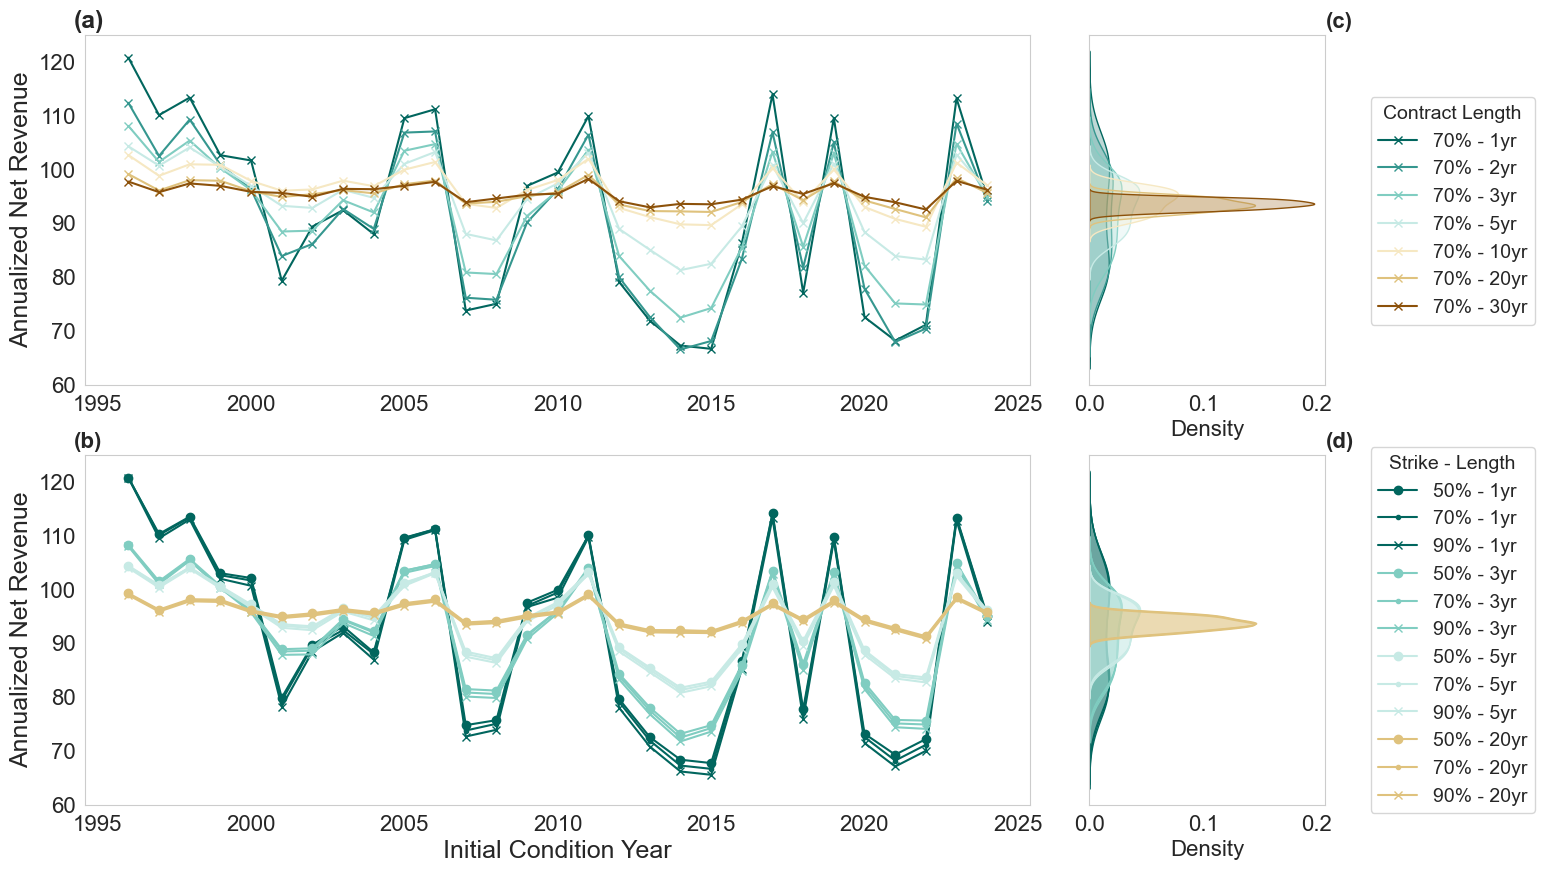

In [16]:
plt.rcParams.update({"font.size": 14,"axes.titlesize": 16,"axes.labelsize": 16,"xtick.labelsize": 13,"ytick.labelsize": 13,"legend.fontsize": 13,"legend.title_fontsize": 14,"font.family": "sans-serif"})
all_lengths = [1,2,3,5,10,20,30]
selected_lengths_for_comparison = [1, 3, 5,20]
selected_strike_for_top = [70]
selected_strikes_for_bottom = [50, 70, 90]

filtered_df = df_output[df_output["Renewal"] == 1]

# ── COLOR PALETTE: brown (long) → teal (short) ──────────────────────────────────
color_map = {"1": "#01665e","2": "#35978f","3": "#80cdc1","5": "#c7eae5","10": "#f6e8c3","20": "#dfc27d", "30": "#8c510a"}

# Use line styles or markers to differentiate strike levels in bottom plot
linestyle_map = {"50": "-", "70": "--", "90": ":"}
marker_map = {50: 'o', 70: ".", 90: "x"}

# ── TOP SUBPLOT DATA ─────────────────────────────────────────────────────────────
df_top = filtered_df[filtered_df["StrikeLevel"].isin(selected_strike_for_top)]
grouped_top = (df_top.groupby(["Year", "ContractLength", "StrikeLevel"])
    .agg({"Revenue": "mean", "Expectation": "mean", "Premium": "mean"})
    .reset_index())

for strike in selected_strike_for_top:
    for contract_length in all_lengths:
        mask = (grouped_top["StrikeLevel"] == strike) & (grouped_top["ContractLength"] == contract_length)
        grouped_top.loc[mask, "NetRevenue"] = (
            grouped_top.loc[mask, "Revenue"]
            + (grouped_top.loc[mask, "Expectation"] / contract_length)
            - (grouped_top.loc[mask, "Premium"] / contract_length)
        )

grouped_top["Label"] = grouped_top["StrikeLevel"].astype(str) + "% - " + grouped_top["ContractLength"].astype(str) + "yr"
pivot_top = grouped_top.pivot(index="Year", columns="Label", values="NetRevenue")

# ── BOTTOM SUBPLOT DATA ──────────────────────────────────────────────────────────
df_bottom = filtered_df[
    (filtered_df["StrikeLevel"].isin(selected_strikes_for_bottom)) &
    (filtered_df["ContractLength"].isin(selected_lengths_for_comparison))
]

grouped_bottom = (df_bottom.groupby(["Year", "ContractLength", "StrikeLevel"])
    .agg({"Revenue": "mean", "Expectation": "mean", "Premium": "mean"})
    .reset_index()
)

grouped_bottom["NetRevenue"] = (
    grouped_bottom["Revenue"]
    + grouped_bottom["Expectation"] / grouped_bottom["ContractLength"]
    - grouped_bottom["Premium"] / grouped_bottom["ContractLength"]
)

fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1], wspace=0.1)

ax_top = fig.add_subplot(gs[0, 0])
ax_top_dist = fig.add_subplot(gs[0, 1])

ax_bot = fig.add_subplot(gs[1, 0], sharex=ax_top)
ax_bot_dist = fig.add_subplot(gs[1, 1], sharex=ax_top_dist)

# ── TOP PLOT: Single Strike Level with all contract lengths ─────────────────────
handles = []
labels = []

for col in sorted(pivot_top.columns, key=lambda x: int(x.split(" - ")[1].replace("yr", ""))):
    strike, length_text = col.split(" - ")
    length = length_text.replace("yr", "").strip()
    line, = ax_top.plot(
        pivot_top.index, pivot_top[col],
        label=col,
        marker=marker_map.get(strike, "x"),
        color=color_map.get(length, "black"),
        linestyle="-"
    )
    handles.append(line)
    labels.append(col)
# ax_top.plot(pivot_top.index, grouped_top[grouped_top['ContractLength'] == 30]['Revenue'], label = 'No mitigation', color = 'black')
ax_top.set_ylabel("Annualized Net Revenue", fontsize=18)
ax_top.set_ylim(60,125)
ax_top.legend(handles, labels, title="Contract Length", fontsize = 14,title_fontsize=14,  bbox_to_anchor=(1.35, 0.85), loc="upper left")
ax_top.grid(False)
ax_top.tick_params(axis='both', labelsize=16)
ax_top.text(-4.3, 2.22, '(a)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold')

print("Strike levels being used:", selected_strikes_for_bottom)
print("Marker for each:", [marker_map.get(strike, 'o') for strike in selected_strikes_for_bottom])

# ── BOTTOM PLOT: Compare Strike Levels within each selected contract length ─────
handles_bottom = []
labels_bottom = []

for length in selected_lengths_for_comparison:
    for strike in selected_strikes_for_bottom:
        subset = grouped_bottom[
            (grouped_bottom["ContractLength"] == length) &
            (grouped_bottom["StrikeLevel"] == strike)
        ].sort_values("Year")

        label = f"{strike}% - {length}yr"
        line, = ax_bot.plot(
            subset["Year"], subset["NetRevenue"],
            label=label,
            color=color_map.get(str(length), "black"),
            # linestyle='linestyle_map.get(strike, "-")',
            marker=marker_map.get(strike, "o")
        )
        handles_bottom.append(line)
        labels_bottom.append(label)
ax_bot.set_ylim(60,125)
ax_bot.set_xlabel("Initial Condition Year", fontsize=18)
ax_bot.set_ylabel("Annualized Net Revenue", fontsize=18)
ax_bot.legend(handles_bottom, labels_bottom, title="Strike - Length", bbox_to_anchor=(1.35, 1.05), loc="upper left", fontsize=14, title_fontsize=14)
ax_bot.grid(False)
ax_bot.tick_params(axis='both', labelsize=16)
ax_bot.text(-4.3, 1.02, '(b)', transform=plt.gca().transAxes, fontsize=16, fontweight='bold')

# ── DISTRIBUTION PLOTS ───────────────────────────────────────────────────────────
for col in sorted(pivot_top.columns, key=lambda x: int(x.split(" - ")[1].replace("yr", ""))):
    strike, length_text = col.split(" - ")
    length = length_text.replace("yr", "").strip()
    
    sns.kdeplot(
        y = pivot_top[col].dropna(),
        ax=ax_top_dist,
        # vertical=True,
        label=length + "yr",
        color=color_map.get(length, "black"),
        fill=True
    )
ax_top_dist.set_ylabel("")
# ax_top_dist.set_yticks(ax_top.get_yticks())
# ax_top_dist.set_xlabel("Density")
ax_top_dist.tick_params(axis='y', left=False, labelleft=False, labelsize=16)
ax_top_dist.tick_params(axis='x',  labelsize=16)
ax_top_dist.grid(False) 
ax_bot.text(1, 2.22, '(c)', transform=plt.gca().transAxes, fontsize=16, fontweight='bold')

for length in selected_lengths_for_comparison:
    for strike in selected_strikes_for_bottom:
        subset = grouped_bottom[
            (grouped_bottom["ContractLength"] == length) &
            (grouped_bottom["StrikeLevel"] == strike)
        ]["NetRevenue"].dropna()

        label = f"{strike}% - {length}yr"
        sns.kdeplot(
            ax=ax_bot_dist,
            y=subset,
            label=label,
            color=color_map.get(str(length), "black"),
            linestyle=linestyle_map.get(strike, "-"),
            fill=True
        )
ax_bot_dist.set_ylabel("")
# ax_bot_dist.set_yticks(ax_bot.get_yticks())
ax_bot_dist.set_xlabel("Density")
ax_bot_dist.tick_params(axis='y', left=False, labelleft=False, labelsize=16)
ax_bot_dist.tick_params(axis='x',  labelsize=16)
ax_bot_dist.grid(False) 
ax_bot.text(1, 1.02, '(d)', transform=plt.gca().transAxes, fontsize=16, fontweight='bold')

# for ax in [ax_top, ax_bot, ax_top_dist, ax_bot_dist]:
#     ax.set_ylim(35, 150) 

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('Figure/index_insurance/annual_net_rev_by_contractlength.png', bbox_inches='tight')
plt.show()


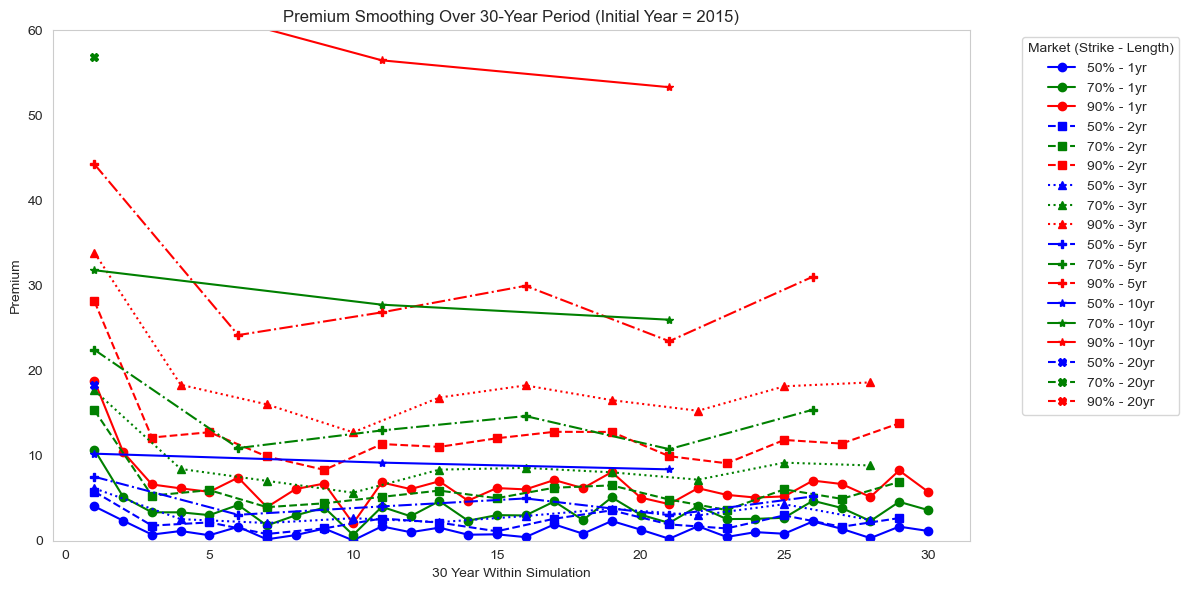

In [57]:
df_2015 = df_output[df_output["Year"] == 2015]
grouped_2015 = df_2015.groupby(["ContractLength", "StrikeLevel", "Renewal"])["Premium"].mean().reset_index()
pivot_2015 = grouped_2015.pivot(index="Renewal", columns=["ContractLength", "StrikeLevel"], values="Premium")

plt.figure(figsize=(12, 6))

contract_lengths = [1, 2, 3, 5, 10, 20]
# Expand markers to cover all contract lengths
markers = {1: 'o', 2: 's', 3: '^', 5: 'P', 10: '*', 20: 'X'}
colors = {50: "blue", 70: "green", 90: "red"}
linestyle_map = {1: "-", 2: "--", 3: ":", 5: '-.', 10: '-', 20: '--'}


for k in contract_lengths:
    for strike in [50, 70, 90]:
        series = pivot_2015[k, strike]
        n_points = len(series)
        x = list(range(1, 1 + k * n_points, k))
        label = f"{strike}% - {k}yr"
        plt.plot(x, series.values, marker=markers[k], color=colors[strike], linestyle=linestyle_map[k], label=label)

plt.title("Premium Smoothing Over 30-Year Period (Initial Year = 2015)")
plt.xlabel("30 Year Within Simulation")
plt.ylabel("Premium")
plt.ylim(0,60)
plt.legend(title="Market (Strike - Length)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()


# Strategy (ML to find closest premium based on intial storage)

In [7]:
df = pd.read_csv("calfews_src/data/input/calfews_src-data.csv") 

df["datetime"] = pd.to_datetime(df["datetime"]) 
oct1_dates = [f"{year}-10-01" for year in range(1996, 2025)]
final_date = ["2024-09-30"]
date_list = pd.to_datetime(oct1_dates + final_date)

storage_columns = [
    "SHA_storage", "ORO_storage", "FOL_storage", "YRS_storage",
    "MIL_storage", "NML_storage", "DNP_storage", "EXC_storage",
    "PFT_storage", "KWH_storage", "SUC_storage", "ISB_storage"]

storage_df = df[df["datetime"].isin(date_list)][["datetime"] + storage_columns]
storage_df['SanJoaquin_storage'] = storage_df['NML_storage'] + storage_df['DNP_storage'] + storage_df['EXC_storage'] 
storage_df['Tulare_storage'] = storage_df['PFT_storage'] + storage_df['KWH_storage'] + storage_df['SUC_storage']+storage_df['ISB_storage']
storage_df["Year"] = pd.to_datetime(storage_df["datetime"]).dt.year
storage_df = storage_df.drop(['datetime', "NML_storage", "DNP_storage", "EXC_storage", "PFT_storage", "KWH_storage", "SUC_storage", "ISB_storage"],axis =1)



In [8]:
df_premium = pd.read_csv("plots/premiums_expectations.csv")
df_premium = df_premium[df_premium["Renewal"] == 1] # filter by the first period for each length
# Create a new column in premium dataframe: "length - strike"
df_premium["length_strike"] = (
    df_premium["ContractLength"].astype(str) + "yr - " + df_premium["StrikeLevel"].astype(str) + "%"
)

premium_pivot = df_premium.pivot_table(
    index="Year",
    columns="length_strike",
    values="Premium"
).reset_index()

df_merged = pd.merge(storage_df, premium_pivot, how="left", on="Year")
# df_merged.to_csv("hhh.csv")

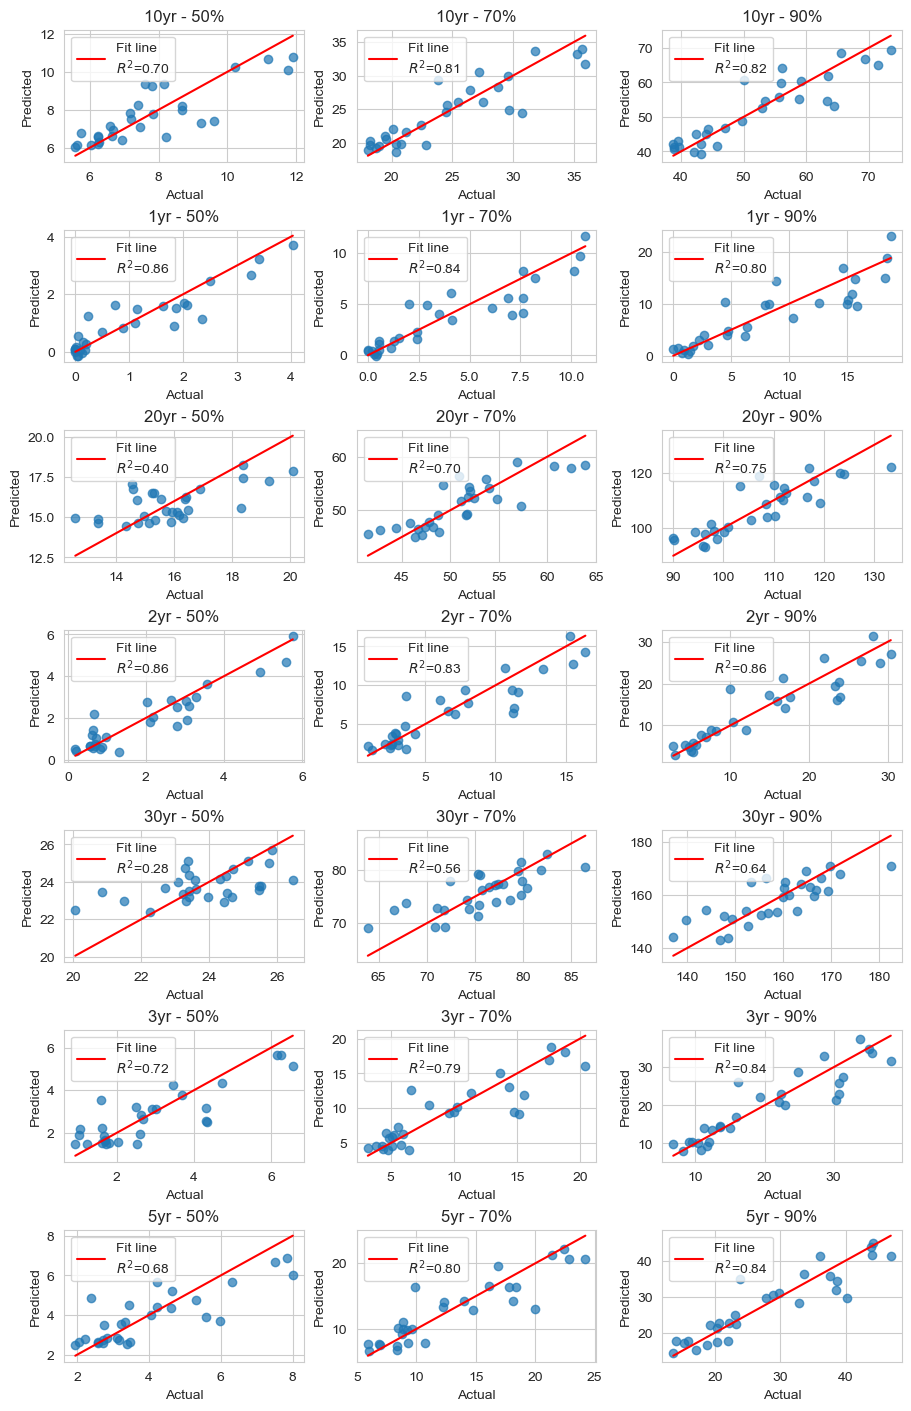

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

storage_cols = ["SHA_storage", "ORO_storage", "FOL_storage", "YRS_storage", "MIL_storage", "SanJoaquin_storage", "Tulare_storage"]
premium_cols = [col for col in df_merged.columns if "yr" in col]

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(df_merged[storage_cols].values)

n_premium_cols = len(premium_cols)
n_cols = 3
n_rows = math.ceil(n_premium_cols / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(9, 2* n_rows), constrained_layout=True)

fitted_models = {}
for i, col in enumerate(premium_cols):
    row = i // n_cols
    col_index = i % n_cols
    ax = axs[row, col_index] if n_rows > 1 else axs[col_index]  # Handle single row cases

    y = df_merged[col].values

    y_transformed = np.log1p(y)  # Log transformation to handle near-zero premiums
    # Use Ridge regression for regularization
    model = Ridge(alpha=0.01)
    model.fit(X, y_transformed)
    fitted_models[col] = model

    y_pred_transformed = model.predict(X)
    y_pred = np.expm1(y_pred_transformed)  # Invert the log transformation
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    ax.scatter(y, y_pred, alpha=0.7)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], color='red', label=f'Fit line\n$R^2$={r2:.2f}')
    ax.set_title(col)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend(loc='upper left')
    ax.grid(True)

plt.show()

In [10]:
import h5py
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer

def extract_storage_values_for_date():
    base_output_folder = "results/30_year/"
    storage_values_list = []
    storage_columns = [
        "shasta_S", "oroville_S", "folsom_S", "yuba_S",
        "millerton_S", "newmelones_S", "donpedro_S", "exchequer_S",
        "pineflat_S", "kaweah_S", "success_S", "isabella_S"
    ]
    for run_number in range(1, 101):
        output_folder = f"{base_output_folder}2024_{run_number}/"
        trace = output_folder + 'results.hdf5'
        datDaily = get_results_sensitivity_number_outside_model(trace, '')
        specific_date_data = datDaily[(datDaily.index.month == 10)&(datDaily.index.day == 1)]
        storage_values = specific_date_data[storage_columns]*1000  #unit conversion
        storage_values['run_number'] = run_number
        storage_values_list.append(storage_values)
    return storage_values_list

resulting_storage_values = extract_storage_values_for_date()

all_storage_values = pd.concat(resulting_storage_values, axis=0)
all_storage_values['SanJoaquin_S'] = all_storage_values['newmelones_S'] + all_storage_values['donpedro_S'] + all_storage_values['exchequer_S'] 
all_storage_values['Tulare_S'] = all_storage_values['pineflat_S'] + all_storage_values['kaweah_S'] + all_storage_values['success_S']+all_storage_values['isabella_S']
all_storage_values = all_storage_values.drop(["newmelones_S", "donpedro_S", "exchequer_S", "pineflat_S", "kaweah_S", "success_S", "isabella_S"],axis =1)
all_storage_values = all_storage_values.rename(columns={"shasta_S": "SHA_storage", "oroville_S": "ORO_storage", "folsom_S": "FOL_storage", "yuba_S": "YRS_storage", "millerton_S": "MIL_storage","SanJoaquin_S": "SanJoaquin_storage","Tulare_S": "Tulare_storage"})
all_storage_values

,SHA_storage,ORO_storage,FOL_storage,YRS_storage,MIL_storage,run_number,SanJoaquin_storage,Tulare_storage
2024-10-01,2.766120e+06,1.888115e+06,460167.000000,649805.000000,248105.000000,1,4.050884e+06,5.968740e+05
2025-10-01,3.306802e+06,2.255308e+06,678776.885841,773792.201221,313619.046312,1,4.627569e+06,9.195152e+05
2026-10-01,4.024501e+06,3.060786e+06,913591.320325,919428.015489,411395.268785,1,4.957478e+06,1.074540e+06
2027-10-01,3.737909e+06,2.301491e+06,674141.213650,707274.368672,319816.047679,1,4.766630e+06,8.472491e+05
2028-10-01,1.695635e+06,1.587999e+06,143809.241632,548750.926086,214590.205553,1,2.688580e+06,2.896591e+05
...,...,...,...,...,...,...,...,...
2049-10-01,1.603914e+06,1.096808e+06,331043.317355,544262.646037,138262.125800,100,2.796772e+06,1.753391e+05
2050-10-01,2.677530e+06,1.753853e+06,658037.261996,768599.260444,189289.901327,100,3.472046e+06,4.951168e+05
2051-10-01,3.348054e+06,2.645636e+06,776547.703890,858738.550123,415107.565970,100,4.444861e+06,7.146334e+05
2052-10-01,3.398305e+06,2.068635e+06,755886.093408,641241.677474,271687.779653,100,4.243484e+06,4.951737e+05


,10yr - 50%,10yr - 70%,10yr - 90%,1yr - 50%,1yr - 70%,1yr - 90%,20yr - 50%,20yr - 70%,20yr - 90%,2yr - 50%,...,2yr - 90%,30yr - 50%,30yr - 70%,30yr - 90%,3yr - 50%,3yr - 70%,3yr - 90%,5yr - 50%,5yr - 70%,5yr - 90%
0,0.695730,2.269792,4.882238,0.699792,2.268328,5.535086,0.766979,2.452326,5.210220,0.699575,...,5.358087,0.77358,2.423572,5.107032,0.721738,2.451926,5.675541,0.701872,2.197356,4.952611
1,0.695730,2.269792,4.882238,0.000000,0.445201,1.703114,0.766979,2.452326,5.210220,0.699575,...,5.358087,0.77358,2.423572,5.107032,0.721738,2.451926,5.675541,0.701872,2.197356,4.952611
2,0.695730,2.269792,4.882238,0.000000,0.000000,0.023737,0.766979,2.452326,5.210220,0.000000,...,1.115793,0.77358,2.423572,5.107032,0.721738,2.451926,5.675541,0.701872,2.197356,4.952611
3,0.695730,2.269792,4.882238,0.000000,0.442755,1.867691,0.766979,2.452326,5.210220,0.000000,...,1.115793,0.77358,2.423572,5.107032,0.456078,1.435296,3.338786,0.701872,2.197356,4.952611
4,0.695730,2.269792,4.882238,2.750179,8.398043,16.554845,0.766979,2.452326,5.210220,1.985500,...,12.901284,0.77358,2.423572,5.107032,0.456078,1.435296,3.338786,0.701872,2.197356,4.952611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.617969,1.859298,3.933650,2.036347,7.563325,17.106578,0.719183,2.363443,5.048728,0.857957,...,7.448584,0.77358,2.423572,5.107032,0.834611,3.199231,7.187963,0.962167,3.620977,7.896618
2996,0.617969,1.859298,3.933650,0.229853,1.836092,4.777835,0.719183,2.363443,5.048728,0.420868,...,5.321188,0.77358,2.423572,5.107032,0.834611,3.199231,7.187963,0.962167,3.620977,7.896618
2997,0.617969,1.859298,3.933650,0.000000,0.318167,1.228160,0.719183,2.363443,5.048728,0.420868,...,5.321188,0.77358,2.423572,5.107032,0.442232,1.626878,3.644889,0.962167,3.620977,7.896618
2998,0.617969,1.859298,3.933650,0.000000,0.874221,2.781204,0.719183,2.363443,5.048728,0.281608,...,3.328543,0.77358,2.423572,5.107032,0.442232,1.626878,3.644889,0.962167,3.620977,7.896618


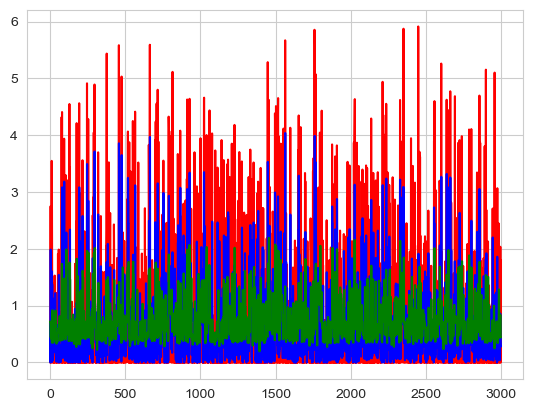

In [11]:
averaged_predictions = {}

for col in premium_cols:
    model = fitted_models[col]
    # Determine the step size based on the contract length from the column name
    step_size = int(col.split('yr')[0].strip())
    selected_rows = all_storage_values.iloc[::step_size]
    
    # Standardize the selected rows
    X_new = scaler.transform(selected_rows[storage_cols].values)
    
    # Predict premiums using the trained model and invert the transformation
    predicted_values_transformed = model.predict(X_new)
    predicted_values = np.expm1(predicted_values_transformed)
    
    # Calculate average values based on the step size
    repeated_indices = np.arange(0, len(predicted_values) * step_size, step_size)
    average_values = np.repeat(predicted_values / step_size, step_size) #step sise is contract length
    average_values[average_values < 0] = 0   #ensure no negative premium
    averaged_predictions[col] = average_values
averaged_predictions = pd.DataFrame(averaged_predictions)
plt.plot(averaged_predictions['1yr - 50%'], color = "red")
plt.plot(averaged_predictions['2yr - 50%'], color = "blue")
plt.plot(averaged_predictions['3yr - 50%'], color = "green")
averaged_predictions

In [12]:
df = pd.read_csv("plots/pumping_vs_revenue_KCWA_30years_longleaf.csv")
df_2024 = df[df["Year"] == 2024]
df_2024 = df_2024.reset_index(drop=True)
df_combined = pd.concat([df_2024, averaged_predictions], axis=1)
mean_value = 2700
strike_90 = 0.9 * mean_value,
strike_70 = 0.7 * mean_value,
strike_50 = 0.5 * mean_value
def calculate_payout(total_pumping, strike_90):
    return slope_kcwa * max(strike_90 - total_pumping, 0)

df_combined['payout_90'] = df_combined['Total Pumping'].apply(lambda x: calculate_payout(x, strike_90[0]))
df_combined['payout_70'] = df_combined['Total Pumping'].apply(lambda x: calculate_payout(x, strike_70[0]))
df_combined['payout_50'] = df_combined['Total Pumping'].apply(lambda x: calculate_payout(x, strike_50))
# df_combined['STR2_index_insurance_1y'] = df_combined['Total Annual Revenue'] + df_combined['payout_50'] - df_combined['1yr - 50%']


In [13]:
for length in range(1, 4):  # For 1, 2, 3 year contracts
    for strike_key in ['50', '70', '90']:
        payout_column = f'payout_{strike_key}'
        insurance_column = f'STR2_index_insurance_{length}y_{strike_key}'
        premium_column = f'{length}yr - {strike_key}%'
        
        df_combined[insurance_column] = (
            df_combined['Total Annual Revenue'] +
            df_combined[payout_column] -
            df_combined[premium_column]
        )
df_combined

,Year,Simulation,Total Pumping,Total Annual Revenue,GroupNumber,10yr - 50%,10yr - 70%,10yr - 90%,1yr - 50%,1yr - 70%,...,payout_50,STR2_index_insurance_1y_50,STR2_index_insurance_1y_70,STR2_index_insurance_1y_90,STR2_index_insurance_2y_50,STR2_index_insurance_2y_70,STR2_index_insurance_2y_90,STR2_index_insurance_3y_50,STR2_index_insurance_3y_70,STR2_index_insurance_3y_90
0,2024,1,3039.379787,99.328808,1,0.695730,2.269792,4.882238,0.699792,2.268328,...,0.000000,98.629017,97.060480,93.793722,98.629233,96.924067,93.970722,98.607070,96.876882,93.653268
1,2024,1,3356.125924,122.142667,2,0.695730,2.269792,4.882238,0.000000,0.445201,...,0.000000,122.142667,121.697467,120.439553,121.443092,119.737926,116.784581,121.420929,119.690741,116.467127
2,2024,1,3091.740245,118.152981,3,0.695730,2.269792,4.882238,0.000000,0.000000,...,0.000000,118.152981,118.152981,118.129244,118.152981,117.732912,117.037188,117.431243,115.701055,112.477441
3,2024,1,2449.475518,94.892076,4,0.695730,2.269792,4.882238,0.000000,0.442755,...,0.000000,94.892076,94.449321,93.024385,94.892076,94.472006,93.776283,94.435998,93.456780,91.553290
4,2024,1,2646.888229,100.859617,5,0.695730,2.269792,4.882238,2.750179,8.398043,...,0.000000,98.109438,92.461575,84.304772,98.874118,94.564504,87.958333,100.403539,99.424321,97.520832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2024,100,1757.300063,63.520669,26,0.617969,1.859298,3.933650,2.036347,7.563325,...,0.000000,61.484321,59.369048,63.709148,62.662712,63.548790,73.367142,62.686058,63.733142,73.627764
2996,2024,100,2418.755337,79.916544,27,0.617969,1.859298,3.933650,0.229853,1.836092,...,0.000000,79.686691,78.080453,75.427808,79.495677,77.789799,74.884455,79.081933,76.717313,73.017681
2997,2024,100,3324.331135,101.408271,28,0.617969,1.859298,3.933650,0.000000,0.318167,...,0.000000,101.408271,101.090104,100.180111,100.987403,99.281526,96.087083,100.966039,99.781393,97.763382
2998,2024,100,3096.432447,95.211989,29,0.617969,1.859298,3.933650,0.000000,0.874221,...,0.000000,95.211989,94.337767,92.430785,94.930381,93.937729,91.883446,94.769756,93.585111,91.567100


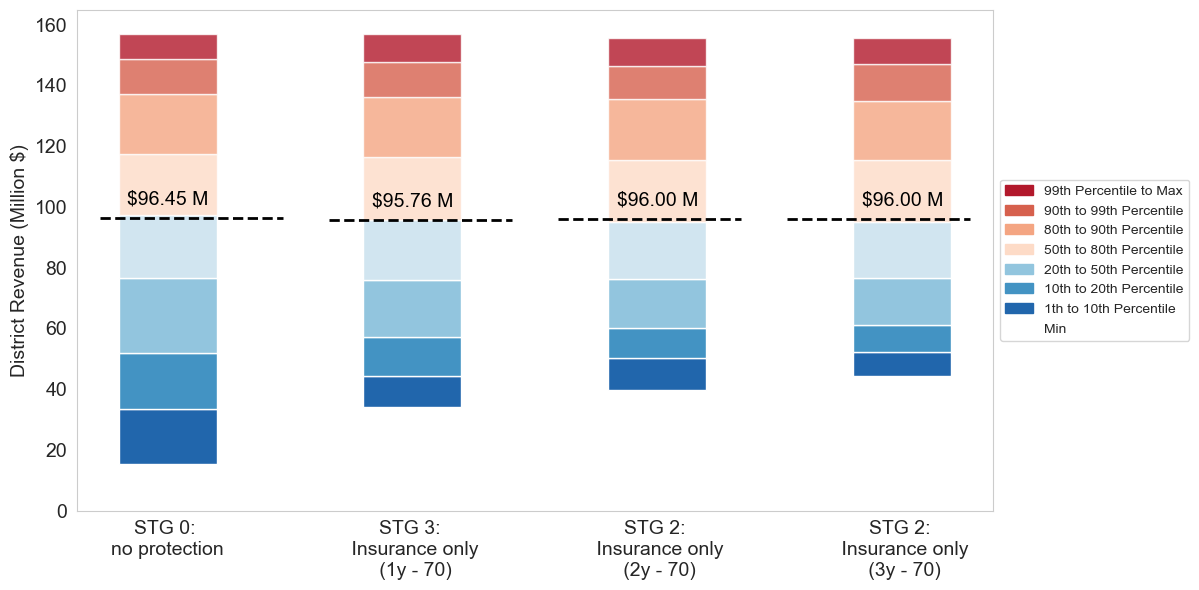

Figure saved as: Figure/index_insurance/strategy_20250619_100012_custom_name.png


In [304]:
dataframes = {
    'STG 0: \nno protection': df_combined['Total Annual Revenue'],
    # 'STG 1: \n Insurance only\n (1y - 50)': df_combined['STR2_index_insurance_1y_50'],
    'STG 3: \n Insurance only\n (1y - 70)': df_combined['STR2_index_insurance_1y_70'],
    # 'STG 2: \n Insurance only\n (1y - 90)': df_combined['STR2_index_insurance_1y_90'],
    # 'STG 2: \n Insurance only\n (2y - 50)': df_combined['STR2_index_insurance_2y_50'],
    'STG 2: \n Insurance only\n (2y - 70)': df_combined['STR2_index_insurance_2y_70'],
    # 'STG 2: \n Insurance only\n (2y - 90)': df_combined['STR2_index_insurance_2y_90'],
    # 'STG 2: \n Insurance only\n (3y - 50)': df_combined['STR2_index_insurance_3y_50'],
    'STG 2: \n Insurance only\n (3y - 70)': df_combined['STR2_index_insurance_3y_70'],
    # 'STG 2: \n Insurance only\n (3y - 90)': df_combined['STR2_index_insurance_3y_90'],
}

unique_filename = plot_water_purchase_costs(dataframes, filename_suffix='custom_name')
print(f"Figure saved as: {unique_filename}")

In [14]:
target_revenue = df_combined['Total Annual Revenue'].mean()

In [36]:
def calculate_contingency_fund(revenue_series, initial_fund, target_revenue, model = "standard", payout_series = None):
    n = len(revenue_series)
    contingency_fund = [initial_fund]  # Starting fund at initial level (CF0)
    additions = [] 
    withdrawals = []

    for i in range(n):
        previous_fund = contingency_fund[-1]
        previous_revenue = revenue_series[i]
        
        if model == "hybrid":
            payout = payout_series[i]
        else:
            payout = 0.0

        available_resources = previous_fund + previous_revenue + payout
        cf_next = min(max(available_resources - min(target_revenue, available_resources), 0), initial_fund)
        
        fund_change = cf_next - previous_fund
        
        # Categorize the change as either addition or withdrawal
        if fund_change > 0:
            additions.append(fund_change)
            withdrawals.append(0)
        else:
            additions.append(0)
            withdrawals.append(-fund_change)  

        contingency_fund.append(cf_next)

    return contingency_fund[:-1], additions, withdrawals

def calculate_annual_cost_cf(initial_fund, interest_rate=0.05, years=30):
    r = interest_rate
    n = years
    annual_cost = initial_fund * (r * (1 + r) ** n) / ((1 + r) ** n - 1)
    return annual_cost

def calculate_CF_cost(revenue_series, initial_fund, target_revenue, model = "standard", payout_series = None):
    contingency_funds, additions, withdrawals = calculate_contingency_fund(revenue_series, initial_fund, target_revenue, model = model, payout_series = payout_series)
    annual_cost = calculate_annual_cost_cf(initial_fund)
    
    n = len(revenue_series)
    annual_cost_series = [annual_cost] * n
    net_cashflow = [withdrawals[i] - additions[i] - annual_cost_series[i] for i in range(n)]
    net_drawdown = [initial_fund - cf - annual_cost for cf in contingency_funds]
    
    return {
        "contingency_fund": contingency_funds,
        "annual_cost": annual_cost,
        "withdrawals": withdrawals,
        "additions": additions,
        "net_cashflow": net_cashflow,
        "net_drawdown": net_drawdown
    }

def apply_contingency_fund_strategy(
    df, initial_funds, model, target_revenue=target_revenue,):
    df_result = df.copy()
    cf_length = 30

    for initial_fund in initial_funds:
        fund_key = int(initial_fund)
        suffix = f"{model}_{fund_key}"

        # choose strategy prefix
        if model == "standard":
            strat_prefix = "STG1"
        else:
            strat_prefix = "STG3"

        # now build every col name with that prefix
        col_cf_net    = f"{strat_prefix}_CF_net_{suffix}"
        col_cf_pool   = f"{strat_prefix}_CF_pool_{suffix}"
        col_with      = f"{strat_prefix}_CF_withdrawal_{suffix}"
        col_add       = f"{strat_prefix}_CF_addition_{suffix}"
        # col_cf_rev    = f"{strat_prefix}_CF_revenue_{suffix}"
        col_strategy  = f"{strat_prefix}_CF_only_{suffix}"

        all_net, all_pool, all_with, all_add = [], [], [], []

        for start in range(0, len(df), cf_length):
            end = start + cf_length
            if end > len(df):
                break
            segment = df.iloc[start:end]
            rev = segment["Total Annual Revenue"].values
            payout = (
                segment["payout_70"].values
                if model == "hybrid"
                else None
            )
            stats = calculate_CF_cost(
                rev,
                initial_fund,
                target_revenue,
                model=model,
                payout_series=payout
            )
            all_net   .extend(stats["net_cashflow"])
            all_pool  .extend(stats["contingency_fund"])
            all_with  .extend(stats["withdrawals"])
            all_add   .extend(stats["additions"])
            # all_cf_rev.extend(stats["CF_revenue"])

        # Trim to original df length
        L = len(df)
        df_result[col_cf_net]   = all_net[:L]
        df_result[col_cf_pool]  = all_pool[:L]
        df_result[col_with]     = all_with[:L]
        df_result[col_add]      = all_add[:L]
        # df_result[col_cf_rev]   = all_cf_rev[:L]

        # Final strategy = CF‐adj revenue + original revenue
        df_result[col_strategy] = (
            df_result[col_cf_net] + df_result["Total Annual Revenue"]
        )

    return df_result


In [48]:
segment = df.iloc[0:30]
revenue_series = segment['Total Annual Revenue'].values
initial_funds = 77
# calculate_CF_cost(revenue_series, initial_funds, target_revenue)['net_cashflow']

In [18]:
segment = df.iloc[0:30]
revenue_series = segment['Total Annual Revenue'].values
initial_funds = 77  # Example: including decimal values
CF = calculate_CF_cost(revenue_series, initial_funds, target_revenue)['net_cashflow']
sum(CF)/len(CF)

-5.008960501181294

In [22]:
#Strategy - contingency fund
initial_funds = [77, 52, 33]
# print(initial_funds)
df_standard = apply_contingency_fund_strategy(df_combined, initial_funds, "standard",  target_revenue)
df_hybrid = apply_contingency_fund_strategy(df_standard, [52],  "hybrid",  target_revenue)
# df_combined.to_csv('plots/all_strategy.csv')

# STR3 hybrid insurance
df_hybrid['STR3_hybrid_1y'] = df_hybrid['Total Annual Revenue'] + df_hybrid['STG3_CF_net_hybrid_52'] + df_hybrid['payout_70'] - df_hybrid['1yr - 70%'] 
df_hybrid['STR3_hybrid_3y'] = df_hybrid['Total Annual Revenue'] + df_hybrid['STG3_CF_net_hybrid_52'] + df_hybrid['payout_70'] - df_hybrid['3yr - 70%'] 

# group_sorted['CF2_revenue'] = calculate_CF_cost(group_sorted, target_revenue * 0.3)
# group_sorted['STR3_inr_payout'] = group_sorted['Total Pumping'].apply(lambda x: calculate_payout(x, slope, strike_50))
# year_premium_map = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_70_2yr)/2)}
# group_sorted['STR3_premium'] = group_sorted['Year'].map(year_premium_map)
# group_sorted['STR3_hybrid'] = group_sorted['Total Annual Revenue'] + group_sorted['CF2_revenue'] + group_sorted['STR3_inr_payout'] - group_sorted['STR3_premium'] 

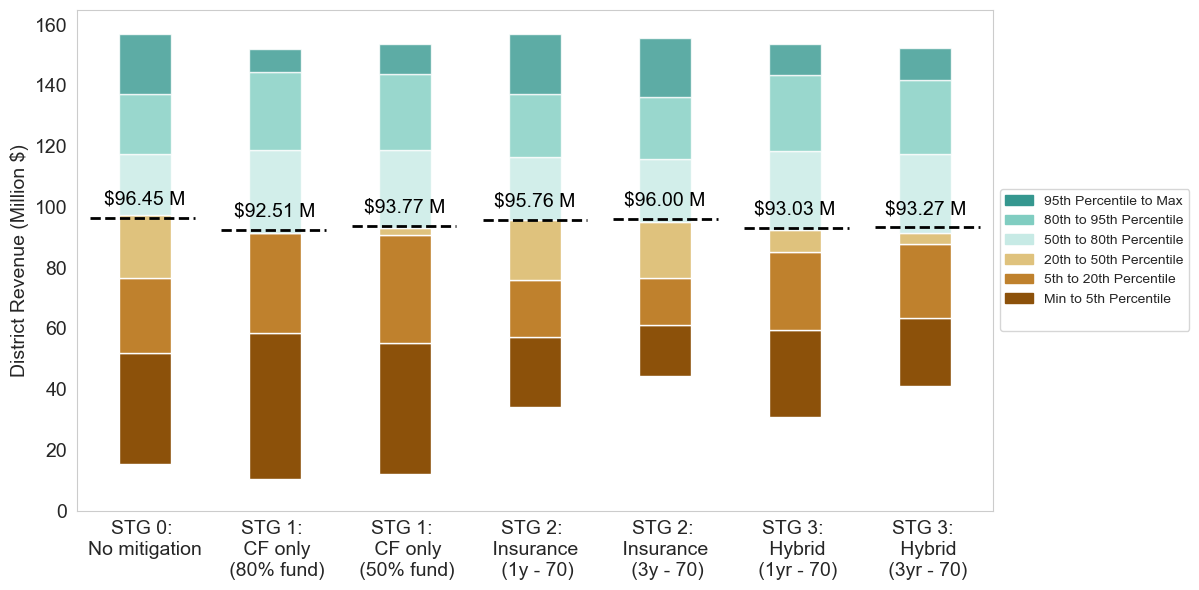

Figure saved as: Figure/index_insurance/strategy_20250630_120852_custom_name.png


In [64]:
dataframes = {
    'STG 0: \nNo mitigation': df_hybrid['Total Annual Revenue'],
    # 'STG 1: \n Insurance only\n (1y - 50)': df_cf['STR2_index_insurance_1y_50'],
    # 'STG 3: \n Insurance only\n (1y - 70)': df_cf['STR2_index_insurance_1y_70'],
    # 'STG 2: \n Insurance only\n (1y - 90)': df_cf['STR2_index_insurance_1y_90'],
    'STG 1: \n CF only\n (80% fund)': df_hybrid['STG1_CF_only_standard_77'],
    'STG 1: \n CF only\n (50% fund)': df_hybrid['STG1_CF_only_standard_52'],
    # 'STG 1: \n CF only\n (.3 fund)': df_combined['STR1_CF_only_33'],
        'STG 2: \n Insurance \n (1y - 70)': df_hybrid['STR2_index_insurance_1y_70'],
    # 'STG 2: \n Insurance \n (2y - 70)': df_combined['STR2_index_insurance_2y_70'],
    'STG 2: \n Insurance \n (3y - 70)': df_hybrid['STR2_index_insurance_3y_70'],
    'STG 3: \n Hybrid\n (1yr - 70)': df_hybrid['STR3_hybrid_1y'],
    'STG 3: \n Hybrid\n (3yr - 70)': df_hybrid['STR3_hybrid_3y'],
}

unique_filename = plot_water_purchase_costs(dataframes, filename_suffix='custom_name')
print(f"Figure saved as: {unique_filename}")

In [91]:
revenue_file = 'plots/pumping_vs_revenue_KCWA_110yr.csv'
Yearly_revenue = pd.read_csv(revenue_file)



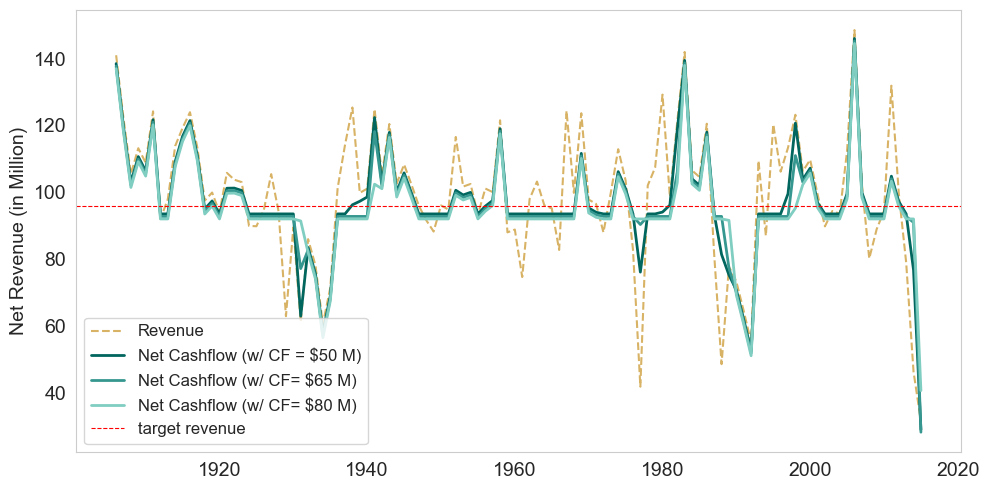

In [123]:
cf, adds, withdraws = calculate_contingency_fund(Yearly_revenue['Annual Revenue'], 50, 96, model="standard", payout_series=None)
cf_65, adds_65, withdraws_65 = calculate_contingency_fund(Yearly_revenue['Annual Revenue'], 65, 96, model="standard", payout_series=None)
cf_80, adds_80, withdraws_80 = calculate_contingency_fund(Yearly_revenue['Annual Revenue'], 80, 96, model="standard", payout_series=None)
bond_cost = calculate_annual_cost_cf(50, interest_rate=0.05, years=110)
bond_cost_65 = calculate_annual_cost_cf(65, interest_rate=0.05, years=110)
bond_cost_80 = calculate_annual_cost_cf(80, interest_rate=0.05, years=110)
net_outflow = Yearly_revenue['Annual Revenue']+ np.array(withdraws) - np.array(adds)  - bond_cost
net_outflow_65 = Yearly_revenue['Annual Revenue']+  np.array(withdraws_65) - np.array(adds_65) - bond_cost_65
net_outflow_80 = Yearly_revenue['Annual Revenue']+ np.array(withdraws_80) - np.array(adds_80) - bond_cost_80
years = np.arange(1906,2016, 1)
plt.figure(figsize=(10, 5))
plt.plot(years, Yearly_revenue['Annual Revenue'], linestyle='--', label='Revenue', color='#d8b365')
plt.plot(years, net_outflow, color='#01665e', label='Net Cashflow (w/ CF = $50 M)', linewidth=2)
plt.plot(years, net_outflow_65, color='#35978f', label='Net Cashflow (w/ CF= $65 M)', linewidth=2)
plt.plot(years, net_outflow_80, color='#80cdc1', label='Net Cashflow (w/ CF= $80 M)', linewidth=2)


# plt.axhline(50, color='black', linewidth=0.8)
plt.axhline(96, color='red', linewidth=0.8, linestyle='--', label='target revenue')

# plt.xlabel("Year", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("Net Revenue (in Million)", fontsize=14)
plt.legend(fontsize=12, loc='lower left')
plt.tight_layout()
plt.grid(False)
plt.show()

In [27]:
three_year_averages = []
all_annual_pumping = []

# Group by simulation-year scenario
for (sim, start_year), df_group in df_combined.groupby(["Simulation", "Year"]):
    # If you have a column like 'SyntheticYear' to indicate year order within scenario, use it
    if "SyntheticYear" in df_group.columns:
        df_sorted = df_group.sort_values("SyntheticYear")
    else:
        df_sorted = df_group.sort_index()  # fallback to row order

    pumping_values = df_sorted["Total Pumping"].values
    all_annual_pumping.extend(pumping_values)  # collect individual annual values

    if len(pumping_values) >= 3:
        for i in range(len(pumping_values) - 2):
            avg_pumping = np.mean(pumping_values[i:i+3])
            three_year_averages.append(avg_pumping)

# Convert to numpy arrays
three_year_averages = np.array(three_year_averages)
all_annual_pumping = np.array(all_annual_pumping)

# Compute thresholds for 3-year averages
threshold_20pct_3yr = np.quantile(three_year_averages, 0.20)
threshold_5pct_3yr  = np.quantile(three_year_averages, 0.05)
threshold_1pct_3yr  = np.quantile(three_year_averages, 0.01)

# Compute thresholds for individual years
threshold_avg_1yr = np.quantile(all_annual_pumping, 0.50)
threshold_20pct_1yr = np.quantile(all_annual_pumping, 0.20)
threshold_5pct_1yr  = np.quantile(all_annual_pumping, 0.05)
threshold_1pct_1yr  = np.quantile(all_annual_pumping, 0.01)

print("=== 3-Year Average Thresholds ===")
print(f"20% threshold: {threshold_20pct_3yr:.2f}")
print(f" 5% threshold: {threshold_5pct_3yr:.2f}")
print(f" 1% threshold: {threshold_1pct_3yr:.2f}")

print("\n=== Individual Year Thresholds ===")
print(f"Average threshold: {threshold_avg_1yr:.2f}")
print(f"20% threshold: {threshold_20pct_1yr:.2f}")
print(f" 5% threshold: {threshold_5pct_1yr:.2f}")
print(f" 1% threshold: {threshold_1pct_1yr:.2f}")


=== 3-Year Average Thresholds ===
20% threshold: 2301.40
 5% threshold: 1678.62
 1% threshold: 1177.93

=== Individual Year Thresholds ===
Average threshold: 2860.72
20% threshold: 2264.49
 5% threshold: 1179.09
 1% threshold: 633.62


In [40]:
df_combined['STR2_index_insurance_1y_70'],
df_combined['STR2_index_insurance_3y_70'],


pi1_threshold_20 = np.quantile(df_combined["STR2_index_insurance_1y_70"], 0.20)
pi1_threshold_5= np.quantile(df_combined["STR2_index_insurance_1y_70"], 0.05)
pi1_threshold_1 = np.quantile(df_combined["STR2_index_insurance_1y_70"], 0.01)

pi3_threshold_20 = np.quantile(df_combined["STR2_index_insurance_3y_70"], 0.20)
pi3_threshold_5= np.quantile(df_combined["STR2_index_insurance_3y_70"], 0.05)
pi3_threshold_1 = np.quantile(df_combined["STR2_index_insurance_3y_70"], 0.01)

print("\n=== Contingency Fund Strategy Thresholds ===")
print(f"20% threshold: {pi1_threshold_20:.2f}")
print(f" 5% threshold: {pi1_threshold_5:.2f}")
print(f" 1% threshold: {pi1_threshold_1:.2f}")

print("\n=== Hybrid Strategy Thresholds ===")
print(f"20% threshold: {pi3_threshold_20:.2f}")
print(f" 5% threshold: {pi3_threshold_5:.2f}")
print(f" 1% threshold: {pi3_threshold_1:.2f}")





=== Contingency Fund Strategy Thresholds ===
20% threshold: 75.93
 5% threshold: 57.30
 1% threshold: 44.48

=== Hybrid Strategy Thresholds ===
20% threshold: 76.54
 5% threshold: 61.16
 1% threshold: 52.37


In [34]:
avg = df_combined["Total Annual Revenue"].mean()
CFA_mean = df_combined['STR1_CF_only_77'].mean()
CFB_mean = df_combined['STR1_CF_only_52'].mean()
STR3_hybrid_1y_mean = df_combined['STR3_hybrid_1y'].mean()
STR3_hybrid_3y_mean = df_combined['STR3_hybrid_3y'].mean()

print("no mitigation mean: ", avg)
print("CFA_mean:",CFA_mean, "CFB_mean:", CFB_mean)
print("CFA_mean - no mitigation: ", CFA_mean - avg, "CFA -CFB: ", CFB_mean - CFA_mean)
print("===STR3_hybrid_1y_mean:", STR3_hybrid_1y_mean, "STR3_hybrid_1y_mean - no mitigation: ", STR3_hybrid_1y_mean - avg)
print("===STR3_hybrid_3y_mean:", STR3_hybrid_3y_mean, "STR3_hybrid_3y_mean - no mitigation: ", STR3_hybrid_3y_mean - avg)

#20 percentile of the total annual revenue
threshold_20_no_mitigation = np.quantile(df_combined["Total Annual Revenue"], 0.20)
threshold_20_CFA = np.quantile(df_combined["STR1_CF_only_77"], 0.20)
threshold_20_CFB = np.quantile(df_combined["STR1_CF_only_52"], 0.20)
threshold_20_HF1 = np.quantile(df_combined["STR3_hybrid_1y"], 0.20)

print(f"20% threshold of total annual revenue: {threshold_20_no_mitigation:.2f}", "CFA:", threshold_20_CFA, "diff:", threshold_20_CFA - threshold_20_no_mitigation)
print(f"20% threshold of CFB: {threshold_20_CFB:.2f}", "diff:", threshold_20_CFB - threshold_20_no_mitigation)
print(f"20% threshold of STR3_hybrid_1y: {threshold_20_HF1:.2f}", "diff:", threshold_20_HF1 - threshold_20_no_mitigation)

#5 percentile of the total annual revenue
threshold_5_no_mitigation = np.quantile(df_combined["Total Annual Revenue"], 0.05)
threshold_5_CFA = np.quantile(df_combined["STR1_CF_only_77"], 0.05)
threshold_5_CFB = np.quantile(df_combined["STR1_CF_only_52"], 0.05)
threshold_5_HF1 = np.quantile(df_combined["STR3_hybrid_1y"], 0.05)
print(f"5% threshold of total annual revenue: {threshold_5_no_mitigation:.2f}", "CFA:", threshold_5_CFA, "diff:", threshold_5_CFA - threshold_5_no_mitigation)
print(f"5% threshold of CFB: {threshold_5_CFB:.2f}", "diff:", threshold_5_CFB - threshold_5_no_mitigation)
print(f"5% threshold of STR3_hybrid_1y: {threshold_5_HF1:.2f}", "diff(HF1-CFB):", threshold_5_HF1 - threshold_5_CFB)
threshold_1_no_mitigation = np.quantile(df_combined["Total Annual Revenue"], 0.01)
threshold_1_CFA = np.quantile(df_combined["STR1_CF_only_77"], 0.01)
threshold_1_CFB = np.quantile(df_combined["STR1_CF_only_52"], 0.01)
threshold_1_HF1 = np.quantile(df_combined["STR3_hybrid_1y"], 0.01)
threshold_1_HF2 = np.quantile(df_combined["STR3_hybrid_3y"], 0.01)
print(f"1% threshold of total annual revenue: {threshold_1_no_mitigation:.2f}")
print(f"1% thresholdCFA:, {threshold_1_CFA:.2f}", f"CFB: {threshold_1_CFB:.2f}", "diff:", f"diff:,{threshold_1_CFB - threshold_1_no_mitigation:.2f}")
print(f"1% threshold of STR3_hybrid_1y: {threshold_1_HF1:.2f}", "diff(HF1-CFA):", threshold_1_HF1 - threshold_1_CFA)
print(f"1% threshold of STR3_hybrid_3y: {threshold_1_HF2:.2f}", "diff(HF2-CFb):", threshold_1_HF2 - threshold_1_CFA)
# print(f"max loss STR3_hybrid_3y: {df_combined["STR3_hybrid_1y"].max():.2f}")


no mitigation mean:  96.45270099902667
CFA_mean: 92.51212118226076 CFB_mean: 93.77016042559187
CFA_mean - no mitigation:  -3.9405798167659185 CFA -CFB:  1.2580392433311118
===STR3_hybrid_1y_mean: 93.08045511445702 STR3_hybrid_1y_mean - no mitigation:  -3.372245884569651
===STR3_hybrid_3y_mean: 93.31855799092133 STR3_hybrid_3y_mean - no mitigation:  -3.1341430081053403
20% threshold of total annual revenue: 76.56 CFA: 91.44374049784537 diff: 14.88617607984537
20% threshold of CFB: 90.76 diff: 14.198799843825626
20% threshold of STR3_hybrid_1y: 84.67 diff: 8.11694595717735
5% threshold of total annual revenue: 51.81 CFA: 58.41563035491603 diff: 6.604936839416034
5% threshold of CFB: 55.17 diff: 3.36006561232562
5% threshold of STR3_hybrid_1y: 57.58 diff(HF1-CFB): 2.407453996801145
1% threshold of total annual revenue: 33.43
1% thresholdCFA:, 32.68 CFB: 32.92 diff: diff:,-0.51
1% threshold of STR3_hybrid_1y: 41.10 diff(HF1-CFA): 8.424938250730982
1% threshold of STR3_hybrid_3y: 49.37 diff

In [39]:
df_combined['STR3_hybrid_3y'].min()- df_combined['STR3_hybrid_1y'].min()
np.quantile(df_combined["STR3_hybrid_3y"], 0.20) - np.quantile(df_combined["STR3_hybrid_1y"], 0.20)


2.3903662478650745

In [470]:
three_year_averages = []

# Group by simulation-year scenario
for (sim, start_year), df_group in df_combined.groupby(["Simulation", "Year"]):
    # If you have a column like 'SyntheticYear' to indicate year order within scenario, use it
    if "SyntheticYear" in df_group.columns:
        df_sorted = df_group.sort_values("SyntheticYear")
    else:
        df_sorted = df_group.sort_index()  # fallback to row order

    pumping_values = df_sorted["Total Pumping"].values

    if len(pumping_values) >= 3:
        for i in range(len(pumping_values) - 2):
            avg_pumping = np.mean(pumping_values[i:i+3])
            three_year_averages.append(avg_pumping)

three_year_averages = np.array(three_year_averages)
threshold_20pct = np.quantile(three_year_averages, 0.20)
threshold_5pct  = np.quantile(three_year_averages, 0.05)
threshold_1pct  = np.quantile(three_year_averages, 0.01)

print(f"20% threshold: {threshold_20pct:.2f} ")
print(f" 5% threshold: {threshold_5pct:.2f} ")
print(f" 1% threshold: {threshold_1pct:.2f}")


20% threshold: 2301.40 
 5% threshold: 1678.62 
 1% threshold: 1177.93


# old code for 3-yr runs

In [10]:
base_output_folder = "plots/pumping_vs_revenue_KCWA_3yr.csv"
start_year = 1996
end_year = 2024
slope = slope_kcwa

# with open('calfews_src/data/mean_value.pkl', 'rb') as f:
#     mean_value = pickle.load(f)
mean_value = 2700 
strike_90 = 0.9 * mean_value
strike_80 = 0.7 * mean_value
strike_70 = 0.5 * mean_value

expectation_of_payouts = []
expectation_of_payouts_2y = []
expectation_of_payouts_3y = []
premium_1yr = []
premium_2yr = []
premium_3yr = []

for year in range(start_year, end_year + 1):
    all_first_years_data = []
    all_second_years_data = []
    all_third_years_data = []

    for i in range(1, 101):
        trace_file = pd.read_csv(base_output_folder)
        #when year is year and simulation is i get the value for column Total Pumping
        delta_HRO_pump_resampled = trace_file['Total Pumping'][(trace_file['Year'] == year) & (trace_file['Simulation'] == i)]
        # print(delta_HRO_pump_resampled)
        
        first_year_value = delta_HRO_pump_resampled.iloc[0]
        second_year_value = delta_HRO_pump_resampled.iloc[1]
        third_year_value = delta_HRO_pump_resampled.iloc[2]
        all_first_years_data.append(first_year_value)
        all_second_years_data.append(second_year_value)
        all_third_years_data.append(third_year_value)

    payouts_90_1yr = [slope * max((strike_90 - f), 0) for f in all_first_years_data]
    # print(f"payouts_90_1yr: {payouts_90_1yr}")
    payouts_80_1yr = [slope * max((strike_80 - f), 0) for f in all_first_years_data]
    payouts_70_1yr = [slope * max((strike_70 - f), 0) for f in all_first_years_data]
    payouts_90_2yr = [slope * max((strike_90 - f), 0) for f in all_second_years_data]
    payouts_80_2yr = [slope * max((strike_80 - f), 0) for f in all_second_years_data]
    payouts_70_2yr = [slope * max((strike_70 - f), 0) for f in all_second_years_data]
    payouts_90_3yr = [slope * max((strike_90 - f), 0) for f in all_third_years_data]
    payouts_80_3yr = [slope * max((strike_80 - f), 0) for f in all_third_years_data]
    payouts_70_3yr = [slope * max((strike_70 - f), 0) for f in all_third_years_data]

    payouts_90_2yr_combined = [a + b for a, b in zip(payouts_90_2yr, payouts_90_1yr)]
    payouts_80_2yr_combined = [a + b for a, b in zip(payouts_80_2yr, payouts_80_1yr)]
    payouts_70_2yr_combined = [a + b for a, b in zip(payouts_70_2yr, payouts_70_1yr)]
    payouts_90_3yr_combined = [a + b + c for a, b, c in zip(payouts_90_3yr, payouts_90_2yr, payouts_90_1yr)]
    payouts_80_3yr_combined = [a + b + c for a, b, c in zip(payouts_80_3yr, payouts_80_2yr, payouts_80_1yr)]
    payouts_70_3yr_combined = [a + b + c for a, b, c in zip(payouts_70_3yr, payouts_70_2yr, payouts_70_1yr)]

    premium_90_1yr = simple_wang_transform(payouts_90_1yr)
    premium_80_1yr = simple_wang_transform(payouts_80_1yr)
    premium_70_1yr = simple_wang_transform(payouts_70_1yr)
    premium_90_2yr = simple_wang_transform(payouts_90_2yr_combined)
    premium_80_2yr = simple_wang_transform(payouts_80_2yr_combined)
    premium_70_2yr = simple_wang_transform(payouts_70_2yr_combined)
    premium_90_3yr = simple_wang_transform(payouts_90_3yr_combined)
    premium_80_3yr = simple_wang_transform(payouts_80_3yr_combined)
    premium_70_3yr = simple_wang_transform(payouts_70_3yr_combined)

    expectation_payout_90_1yr = np.mean(payouts_90_1yr)
    expectation_payout_80_1yr = np.mean(payouts_80_1yr)
    expectation_payout_70_1yr = np.mean(payouts_70_1yr)
    expectation_payout_90_2yr = np.mean(payouts_90_2yr_combined)
    expectation_payout_80_2yr = np.mean(payouts_80_2yr_combined)
    expectation_payout_70_2yr = np.mean(payouts_70_2yr_combined)
    expectation_payout_90_3yr = np.mean(payouts_90_3yr_combined)
    expectation_payout_80_3yr = np.mean(payouts_80_3yr_combined)
    expectation_payout_70_3yr = np.mean(payouts_70_3yr_combined)

    expectation_of_payouts.append((expectation_payout_90_1yr, expectation_payout_80_1yr, expectation_payout_70_1yr))
    expectation_of_payouts_2y.append((expectation_payout_90_2yr, expectation_payout_80_2yr, expectation_payout_70_2yr))
    expectation_of_payouts_3y.append((expectation_payout_90_3yr, expectation_payout_80_3yr, expectation_payout_70_3yr))

    premium_1yr.append((premium_90_1yr, premium_80_1yr, premium_70_1yr))
    premium_2yr.append((premium_90_2yr, premium_80_2yr, premium_70_2yr))
    premium_3yr.append((premium_90_3yr, premium_80_3yr, premium_70_3yr))


# Convert to arrays for easy plotting
expectation_payout_90s, expectation_payout_80s, expectation_payout_70s = zip(*expectation_of_payouts)
expectation_payout_90_2yr, expectation_payout_80_2yr, expectation_payout_70_2yr = zip(*expectation_of_payouts_2y)
expectation_payout_90_3yr, expectation_payout_80_3yr, expectation_payout_70_3yr = zip(*expectation_of_payouts_3y)

premium_90_1yr, premium_80_1yr, premium_70_1yr = zip(*premium_1yr)
premium_90_2yr, premium_80_2yr, premium_70_2yr = zip(*premium_2yr)
premium_90_3yr, premium_80_3yr, premium_70_3yr = zip(*premium_3yr)

c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


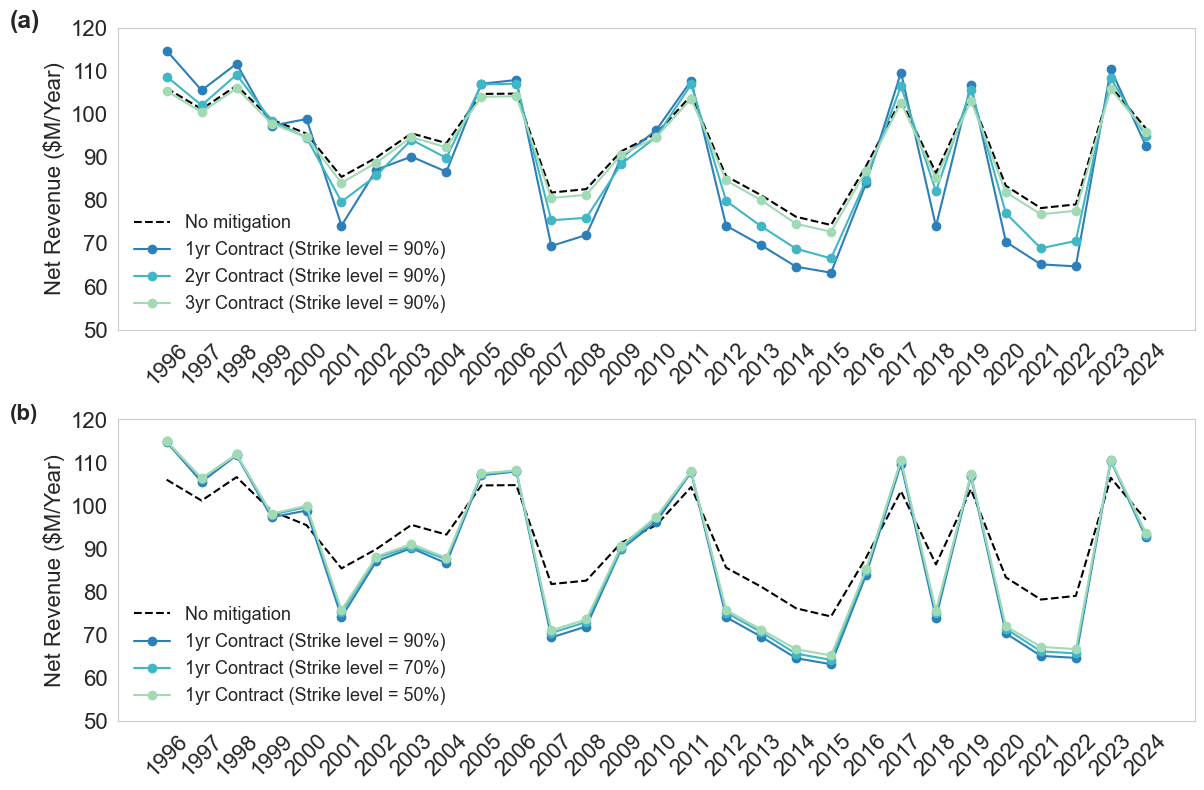

In [449]:
plt.figure(figsize=(12, 8))
years = np.arange(start_year, end_year + 1)
x_indices = np.arange(len(years))
avg_rev_3yr =group_sorted.groupby(['Year'])['Total Annual Revenue'].mean()
plt.subplot(211)
plt.plot(years, tuple(np.array(avg_rev_3yr)), label='No mitigation',color ='black', linestyle='--')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(filtered_2y['Total Annual Revenue']) + np.array(expectation_payout_90_2yr)/2 - np.array(premium_90_2yr)/2), label='2yr Contract (Strike level = 90%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(filtered_3y['Total Annual Revenue']) + np.array(expectation_payout_90_3yr)/3 - np.array(premium_90_3yr)/3), label='3yr Contract (Strike level = 90%)', marker='o', color='#a1dab4')
plt.ylabel('Net Revenue ($M/Year)', fontsize=16)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.ylim(50, 120)
plt.legend(fontsize=13, framealpha=0.2, frameon=False)
plt.grid(False)
plt.text(-0.1, 1, '(a)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold')

plt.subplot(212)
plt.plot(years, tuple(np.array(avg_rev_3yr)), label='No mitigation',color ='black', linestyle='--')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue'])+ np.array(expectation_payout_80s) - np.array(premium_80_1yr)), label='1yr Contract (Strike level = 70%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue'])+ np.array(expectation_payout_70s) - np.array(premium_70_1yr)), label='1yr Contract (Strike level = 50%)', marker='o', color='#a1dab4')

plt.ylabel('Net Revenue ($M/Year)', fontsize=16)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.ylim(50, 120)
plt.legend(fontsize=13, framealpha=0.2, frameon=False)  
plt.grid(False)
plt.text(-0.1, 1, '(b)', transform=plt.gca().transAxes, fontsize=16, fontweight='bold')
# plt.subplot(313)
# plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_70s) - np.array(premium_70_1yr)), label='1yr Contract (Strike level = 70%)', marker='o', color='#2c7fb8')
# plt.plot(years, tuple(np.array(filtered_2y['Total Annual Revenue']) + np.array(expectation_payout_70_2yr)/2 - np.array(premium_70_2yr)/2), label='2yr Contract (Strike level = 70%)', marker='o',color='#41b6c4')
# plt.plot(years, tuple(np.array(filtered_3y['Total Annual Revenue']) + np.array(expectation_payout_70_3yr)/3 - np.array(premium_70_3yr)/3), label='3yr Contract (Strike level = 70%)', marker='o', color='#a1dab4')

# plt.ylabel('Net Payout ($M/Year)', fontsize=16)
# # plt.title('Expectation of Payouts per Contract Period', fontsize=18)
# plt.xticks(years, fontsize=14, rotation=45)
# plt.yticks(fontsize=16)
# # plt.ylim(-0.35, 0.05)
# plt.legend(fontsize=10)
# plt.grid(False)
plt.tight_layout()

plt.show()

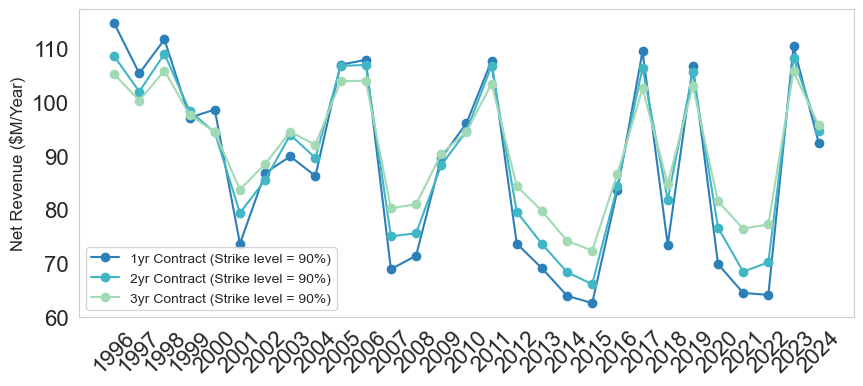

In [18]:
plt.figure(figsize=(10, 4))
start_year = 1996
end_year = 2024
years = np.arange(start_year, end_year + 1)

plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(filtered_2y['Total Annual Revenue']) + np.array(expectation_payout_90_2yr)/2 - np.array(premium_90_2yr)/2), label='2yr Contract (Strike level = 90%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(filtered_3y['Total Annual Revenue']) + np.array(expectation_payout_90_3yr)/3 - np.array(premium_90_3yr)/3), label='3yr Contract (Strike level = 90%)', marker='o', color='#a1dab4')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Net Revenue ($M/Year)', fontsize=12)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)

In [388]:
def calculate_payout(total_pumping, slope, strike_90):
    return slope * max(strike_90 - total_pumping, 0)

# calculate payout & premium for each insurance group
group_sorted['payout'] = group_sorted['Total Pumping'].apply(lambda x: calculate_payout(x, slope, strike_90))
year_premium_map_1y = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_90_1yr))} 
year_premium_map_2y = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_90_2yr)/2)}
year_premium_map_3y = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_90_3yr)/3)}
group_sorted['premium_1y'] = group_sorted['Year'].map(year_premium_map_1y)
group_sorted['premium_2y'] = group_sorted['Year'].map(year_premium_map_2y)
group_sorted['premium_3y'] = group_sorted['Year'].map(year_premium_map_3y)
group_sorted['STR2_index_insurance_1y'] = group_sorted['Total Annual Revenue'] + group_sorted['payout']- group_sorted['premium_1y']
group_sorted['STR2_index_insurance_2y'] = group_sorted['Total Annual Revenue'] + group_sorted['payout']- group_sorted['premium_2y']
group_sorted['STR2_index_insurance_3y'] = group_sorted['Total Annual Revenue'] + group_sorted['payout']- group_sorted['premium_3y']

def calculate_contingency_fund(revenue_series, initial_fund, target_revenue):
    n = len(revenue_series)
    contingency_fund = [initial_fund]  # Starting fund at initial level (CF0)
    
    for i in range(1, n):
        previous_fund = contingency_fund[i-1]
        previous_revenue = revenue_series[i-1]
        
        cf_next = min(max(previous_fund + previous_revenue - min(target_revenue, previous_fund + previous_revenue), 0), initial_fund)
        contingency_fund.append(cf_next)
    
    return contingency_fund

def calculate_annual_cost_cf(initial_fund, interest_rate=0.05, years=3):
    r = interest_rate
    n = years
    annual_cost = initial_fund * (r * (1 + r) ** n) / ((1 + r) ** n - 1)
    # print(f"Annual cost of the fund: {annual_cost/initial_fund:.2%} of the initial fund")
    return annual_cost
def calculate_CF_cost(group_sorted, initial_fund, target_revenue=92):
    results = []
    
    for i in range(0, len(group_sorted), 3):
        scenario = group_sorted.iloc[i:i+3]
        revenue_series = scenario['Total Annual Revenue'].values
        contingency_funds = calculate_contingency_fund(revenue_series, initial_fund, target_revenue)
        annual_cost = calculate_annual_cost_cf(initial_fund)
        
        for j in range(3):
            contingency_fund_revenue = initial_fund - contingency_funds[j] - annual_cost
            results.append(contingency_fund_revenue)
    
    return results

In [400]:
#STR1 contignency fund
group_sorted['CF1_revenue'] = calculate_CF_cost(group_sorted, target_revenue * 0.8)
group_sorted['STR1_CF_only'] = group_sorted['CF1_revenue'] + group_sorted['Total Annual Revenue']

# STR3 hybrid insurance
group_sorted['CF2_revenue'] = calculate_CF_cost(group_sorted, target_revenue * 0.3)
group_sorted['STR3_inr_payout'] = group_sorted['Total Pumping'].apply(lambda x: calculate_payout(x, slope, strike_70))
year_premium_map = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_70_2yr)/2)}
group_sorted['STR3_premium'] = group_sorted['Year'].map(year_premium_map)
group_sorted['STR3_hybrid'] = group_sorted['Total Annual Revenue'] + group_sorted['CF2_revenue'] + group_sorted['STR3_inr_payout'] - group_sorted['STR3_premium'] 


group_sorted.head(25)


,Year,Simulation,Total Pumping,Total Annual Revenue,GroupNumber,CF1_revenue,STR1_CF_only,CF2_revenue,STR3_inr_payout,STR3_premium,STR3_hybrid,payout,premium_1y,premium_2y,premium_3y,STR2_index_insurance_1y,STR2_index_insurance_2y,STR2_index_insurance_3y
0,1996,1,3271.996763,107.383530,1,-27.026550,80.356979,-10.134956,0.000000,0.27606,96.972513,0.000000,0.509882,2.564098,4.338095,106.873648,104.819432,103.045435
1,1996,1,3650.627788,127.913332,2,-27.026550,100.886781,-10.134956,0.000000,0.27606,117.502315,0.000000,0.509882,2.564098,4.338095,127.403450,125.349233,123.575236
2,1996,1,3079.575652,120.738186,3,-27.026550,93.711636,-10.134956,0.000000,0.27606,110.327169,0.000000,0.509882,2.564098,4.338095,120.228304,118.174088,116.400091
3,1996,2,3246.227921,111.015873,1,-27.026550,83.989323,-10.134956,0.000000,0.27606,100.604856,0.000000,0.509882,2.564098,4.338095,110.505992,108.451775,106.677778
4,1996,2,3368.090802,114.107345,2,-27.026550,87.080795,-10.134956,0.000000,0.27606,103.696328,0.000000,0.509882,2.564098,4.338095,113.597463,111.543247,109.769250
5,1996,2,2961.953422,134.796910,3,-27.026550,107.770359,-10.134956,0.000000,0.27606,124.385893,0.000000,0.509882,2.564098,4.338095,134.287028,132.232812,130.458815
6,1996,3,3229.244600,94.536692,1,-27.026550,67.510142,-10.134956,0.000000,0.27606,84.125675,0.000000,0.509882,2.564098,4.338095,94.026811,91.972594,90.198597
7,1996,3,2501.792189,70.501556,2,-27.026550,43.475006,-10.134956,0.000000,0.27606,60.090539,0.000000,0.509882,2.564098,4.338095,69.991674,67.937458,66.163461
8,1996,3,2949.886379,105.249010,3,-5.528106,99.720904,11.363488,0.000000,0.27606,116.336437,0.000000,0.509882,2.564098,4.338095,104.739129,102.684912,100.910915
9,1996,4,3105.636655,96.107491,1,-27.026550,69.080941,-10.134956,0.000000,0.27606,85.696474,0.000000,0.509882,2.564098,4.338095,95.597609,93.543393,91.769396


 STR0 (No protection): Mean: 92.41 Million, Bottom 5%: 44.76 Million
 STR1 (Contingency fund only): Mean: 75.45 Million, Bottom 5%: 30.93 Million
 STR2 (Parametric insurance only):Mean:  90.06 Million, Bottom 5%: 55.61 Million
 STR3 (Hybrid (Insurance + CF)): Mean:  90.38 Million, Bottom 5%: 49.75 Million


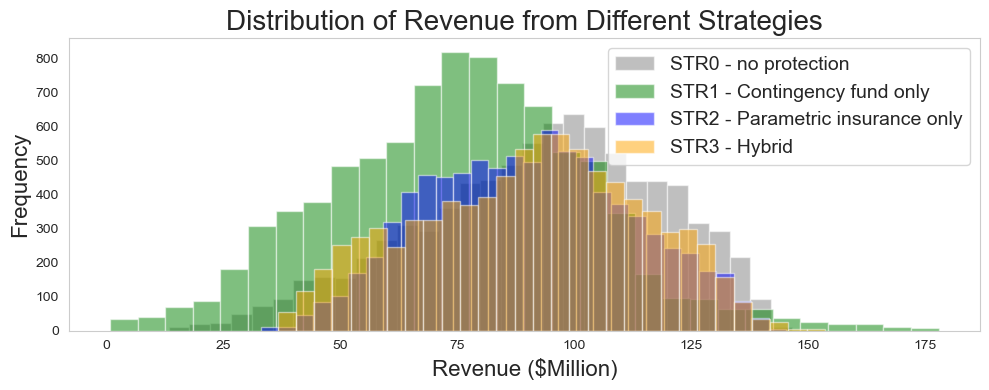

In [398]:
#plot distribution of STR2_rev_insurance, STR3_hybrid, STR1_rev_CF_only
#also print the mean and bottom 10% of each strategy
mean_STR0 = group_sorted['Total Annual Revenue'].mean()
mean_STR2 = group_sorted['STR2_index_insurance_1y'].mean()
mean_STR3 = group_sorted['STR3_hybrid'].mean()
mean_STR1 = group_sorted['STR1_CF_only'].mean()
bottom_10_STR0 = group_sorted['Total Annual Revenue'].quantile(0.05)
bottom_10_STR2 = group_sorted['STR2_index_insurance_1y'].quantile(0.05)
bottom_10_STR3 = group_sorted['STR3_hybrid'].quantile(0.05)
bottom_10_STR1 = group_sorted['STR1_CF_only'].quantile(0.05)

print(f" STR0 (No protection): Mean: {mean_STR0:.2f} Million, Bottom 5%: {bottom_10_STR0:.2f} Million")
print(f" STR1 (Contingency fund only): Mean: {mean_STR1:.2f} Million, Bottom 5%: {bottom_10_STR1:.2f} Million")
print(f" STR2 (Parametric insurance only):Mean:  {mean_STR2:.2f} Million, Bottom 5%: {bottom_10_STR2:.2f} Million")
print(f" STR3 (Hybrid (Insurance + CF)): Mean:  {mean_STR3:.2f} Million, Bottom 5%: {bottom_10_STR3:.2f} Million")

plt.figure(figsize=(10, 4))
plt.hist(group_sorted['Total Annual Revenue'], bins=30, alpha=0.5, label='STR0 - no protection', color='grey')
plt.hist(group_sorted['STR1_CF_only'], bins=30, alpha=0.5, label='STR1 - Contingency fund only', color='green')
plt.hist(group_sorted['STR2_index_insurance_1y'], bins=30, alpha=0.5, label='STR2 - Parametric insurance only', color='blue')
plt.hist(group_sorted['STR3_hybrid'], bins=30, alpha=0.5, label='STR3 - Hybrid', color='orange')
plt.xlabel('Revenue ($Million)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Revenue from Different Strategies', fontsize=20)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [282]:
# group_sorted.loc[group_sorted['GroupNumber'] != 1, 'STR2_index_insurance_1y'] = None
# group_sorted.loc[~group_sorted['GroupNumber'].isin([1, 2]), 'STR2_index_insurance_2y'] = None
# group_sorted.loc[~group_sorted['GroupNumber'].isin([1, 2, 3]), 'STR2_index_insurance_3y'] = None
# group_sorted

In [ ]:
#90 percentile of STR2_index_insurance_1y, STR2_index_insurance_2y, STR2_index_insurance_3y
print(group_sorted['Total Annual Revenue'].mean())
print(group_sorted['Total Annual Revenue'].quantile(0.20))
print(group_sorted['Total Annual Revenue'].quantile(0.05))
print(group_sorted['Total Annual Revenue'].quantile(0.01))

# print(group_sorted['STR2_index_insurance_1y'].quantile(0.01))
# print(group_sorted['STR2_index_insurance_2y'].quantile(0.01))
# print(group_sorted['STR2_index_insurance_3y'].quantile(0.01))
# print(group_sorted['STR2_index_insurance_1y'].mean()) #renew insurance every year
# print(group_sorted['STR2_index_insurance_2y'].mean()) #renew insurance every 2 years , not rounded up, since i only have 3 year time series!
# print(group_sorted['STR2_index_insurance_3y'].mean()) #renew insurance every 3 years


92.41288241992275
69.8823121301545
44.75766392453089
29.975506789597517


Mean cost for STG 0: 
no protection: $92.41 M
Mean cost for STG 1: 
 Contingency
 fund only: $75.45 M
Mean cost for STG 3: 
 Hybrid: $88.72 M
Mean cost for STG 2: 
 Insurance only
 (1y): $90.06 M
Mean cost for STG 2: 
 Insurance only
 (2y): $91.78 M
Mean cost for STG 2: 
 Insurance only
 (3y): $91.21 M


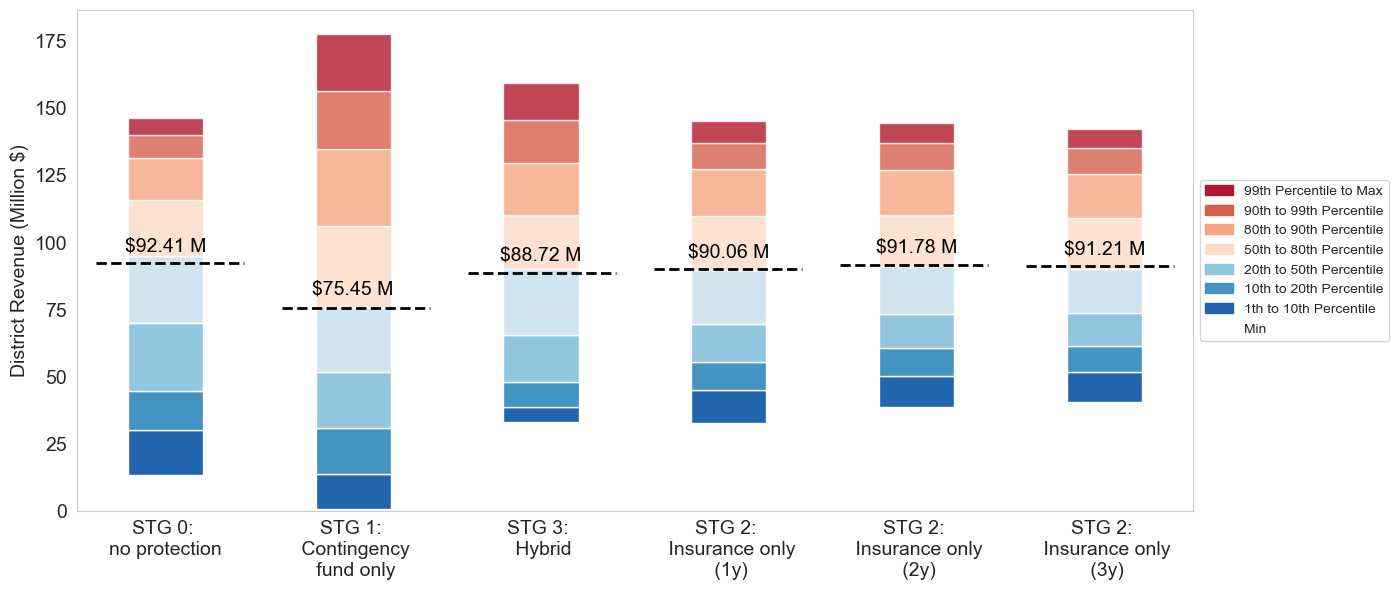

Figure saved as: Figure/index_insurance/strategy_20250613_180952_custom_name.png


In [402]:
dataframes = {
    'STG 0: \nno protection': group_sorted['Total Annual Revenue'],
    'STG 1: \n Contingency\n fund only': group_sorted['STR1_CF_only'],
    'STG 3: \n Hybrid': group_sorted['STR3_hybrid'],
    'STG 2: \n Insurance only\n (1y)': group_sorted['STR2_index_insurance_1y'],
    'STG 2: \n Insurance only\n (2y)': group_sorted['STR2_index_insurance_2y'],
    'STG 2: \n Insurance only\n (3y)': group_sorted['STR2_index_insurance_3y'],
}

# Specify a unique suffix for the filename
unique_filename = plot_water_purchase_costs(dataframes, filename_suffix='custom_name')
print(f"Figure saved as: {unique_filename}")

In [ ]:
target_revenue = 92  # Target revenue
initial_fund = target_revenue*0.5 # Assume the fund is initially seeded with $50,000

results = []
for i in range(0, len(group_sorted), 3):
    scenario = group_sorted.iloc[i:i+3]
    revenue_series = scenario['Total Annual Revenue'].values
    contingency_funds = calculate_contingency_fund(revenue_series, initial_fund, target_revenue)
    annual_cost = calculate_annual_cost_cf(initial_fund)
    for j in range(3):
        contingency_fund_revenue = 46 - contingency_funds[j] - annual_cost
        results.append(contingency_fund_revenue)

# Ensure results length matches the DataFrame length
group_sorted['Contingency_fund_revenue'] = results
group_sorted['STR1_rev_CF_only'] = group_sorted['Contingency_fund_revenue'] + group_sorted['Total Annual Revenue']

group_sorted.head(20)

,Year,Simulation,Total Pumping,Total Annual Revenue,GroupNumber,payout,premium,STR2_rev_insurance,Contingency_fund_revenue,STR1_rev_CF_only
0,1996,1,3271.996763,107.383530,1,0.0,1.007372,106.376158,-2.992366,104.391164
1,1996,1,3650.627788,127.913332,2,0.0,1.007372,126.905959,-2.992366,124.920966
2,1996,1,3079.575652,120.738186,3,0.0,1.007372,119.730814,-2.992366,117.745820
3,1996,2,3246.227921,111.015873,1,0.0,1.007372,110.008501,-2.992366,108.023507
4,1996,2,3368.090802,114.107345,2,0.0,1.007372,113.099973,-2.992366,111.114979
5,1996,2,2961.953422,134.796910,3,0.0,1.007372,133.789537,-2.992366,131.804544
6,1996,3,3229.244600,94.536692,1,0.0,1.007372,93.529320,-2.992366,91.544326
7,1996,3,2501.792189,70.501556,2,0.0,1.007372,69.494184,-2.992366,67.509190
8,1996,3,2949.886379,105.249010,3,0.0,1.007372,104.241638,18.506078,123.755088
9,1996,4,3105.636655,96.107491,1,0.0,1.007372,95.100119,-2.992366,93.115125


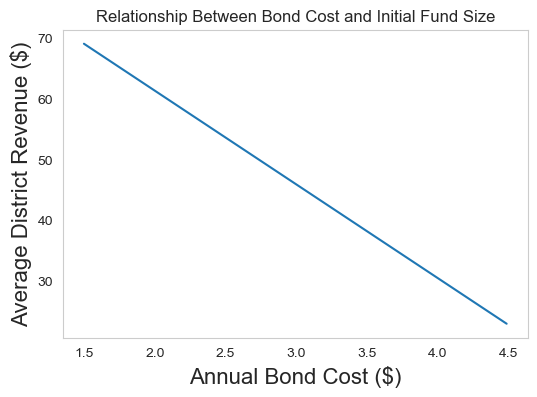

In [67]:
initial_fund_sizes = np.linspace(initial_fund * 0.5, initial_fund * 1.5, num=100)
annual_costs = [calculate_annual_cost_cf(fund) for fund in initial_fund_sizes]
district_rev = target_revenue-initial_fund_sizes   # should be actural district revenue
plt.figure(figsize=(6, 4))
plt.plot(annual_costs, district_rev, label="Annual Cost of Initial Fund")
plt.title("Relationship Between Bond Cost and Initial Fund Size")
plt.ylabel("Average District Revenue ($)", fontsize=16)
plt.xlabel("Annual Bond Cost ($)", fontsize=16)
plt.grid(False)
# plt.legend()
plt.show()

Mean Annual Revenue: 92.41288241992275
5th Percentile Annual Revenue: 44.75766392453089


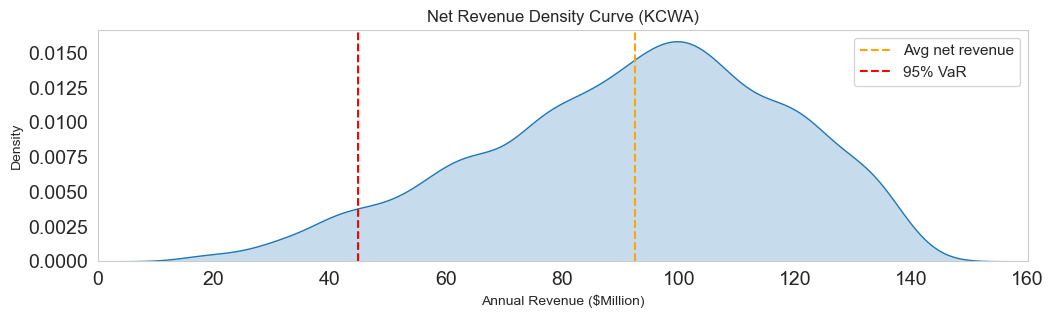

In [29]:
plt.figure(figsize=(12, 3))
sns.kdeplot(group_sorted['Total Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve (KCWA)")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['Total Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(group_sorted['Total Annual Revenue'])}")
first_percentile = np.percentile(group_sorted['Total Annual Revenue'], 5)
print(f"5th Percentile Annual Revenue: {first_percentile}")
plt.axvline(x = first_percentile, color='red', linestyle='--', label='95% VaR')

# plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 160)

plt.legend(fontsize=11, loc ='upper right')
plt.grid(False)
# plt.savefig('plots/net_revenue_density_curve_noContract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 92.04468282836939
5th Percentile Annual Revenue: 56.42698601562085


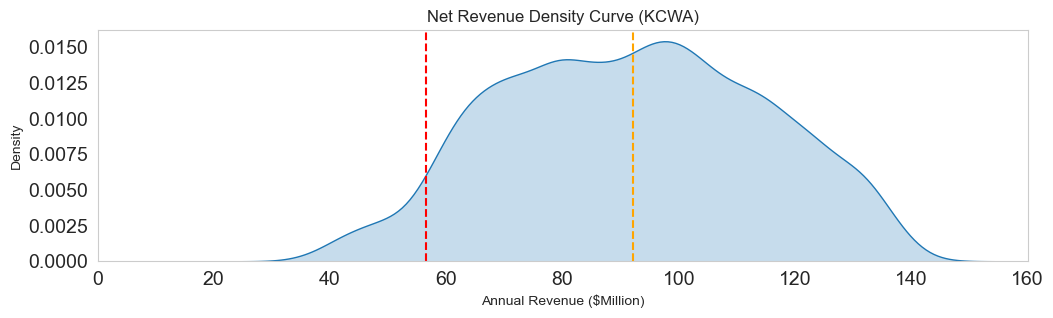

In [27]:

plt.figure(figsize=(12, 3))
sns.kdeplot(group_sorted['net_rev'], fill=True)
plt.title("Net Revenue Density Curve (KCWA)")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['net_rev']), color='orange', linestyle='--', label='Mean')
print(f"Mean Annual Revenue: {np.mean(group_sorted['net_rev'])}")

first_percentile_net = np.percentile(group_sorted['net_rev'], 5)
print(f"5th Percentile Annual Revenue: {first_percentile_net}")
plt.axvline(x = first_percentile_net, color='red', linestyle='--', label='95% VaR')
plt.ylabel("Density")
plt.xlim(0, 160)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
# plt.savefig('plots/net_revenue_density_curve_2yrcontract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 92.04468282836939
1th Percentile Annual Revenue: 43.57793308243553


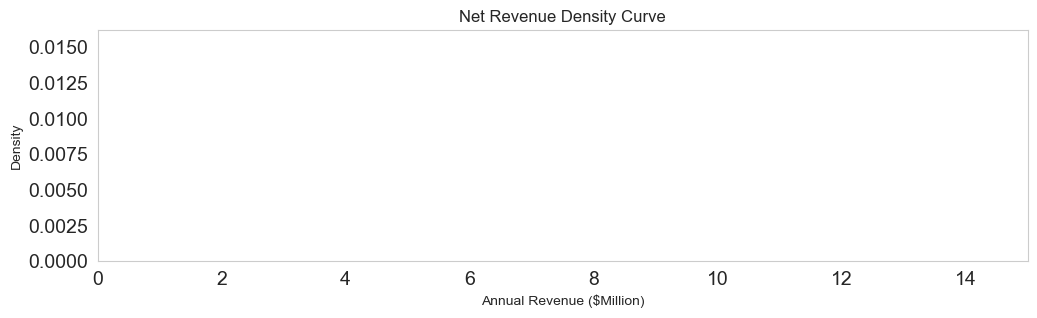

In [28]:


plt.figure(figsize=(12, 3))

sns.kdeplot(group_sorted['net_rev'], fill=True)
plt.title("Net Revenue Density Curve")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['net_rev']), color='orange', linestyle='--', label='Mean')
print(f"Mean Annual Revenue: {np.mean(group_sorted['net_rev'])}")

first_percentile = np.percentile(group_sorted['net_rev'], 1)
print(f"1th Percentile Annual Revenue: {first_percentile}")
plt.axvline(x = first_percentile, color='red', linestyle='--', label='99% VaR')
plt.ylabel("Density")
plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('plots/net_revenue_density_curve_2yrcontract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 9.339671718005873
1st Percentile Annual Revenue: 4.283896562736899


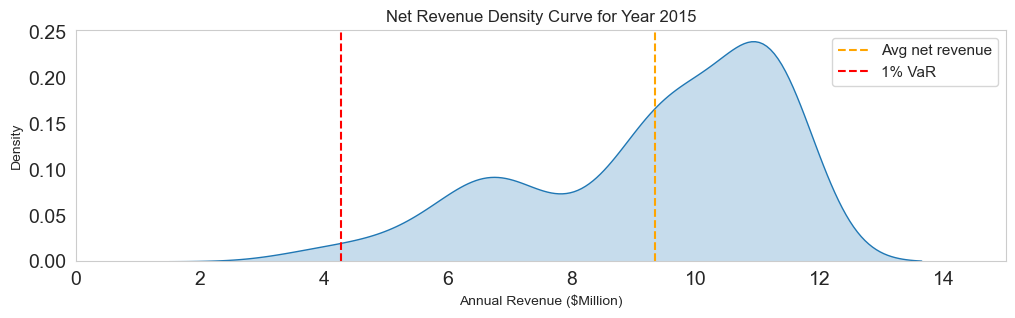

In [22]:
filtered_data = group_sorted[group_sorted['Year'] == 2024]

plt.figure(figsize=(12, 3))
sns.kdeplot(filtered_data['Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve for Year 2015")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x=np.mean(filtered_data['Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(filtered_data['Annual Revenue'])}")

first_percentile = np.percentile(filtered_data['Annual Revenue'], 1)
print(f"1st Percentile Annual Revenue: {first_percentile}")
plt.axvline(x=first_percentile, color='red', linestyle='--', label='1% VaR')

plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='upper right')
plt.grid(False)
plt.savefig('plots/net_revenue_density_curve_2024.png', dpi=300, bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Total Pumping')

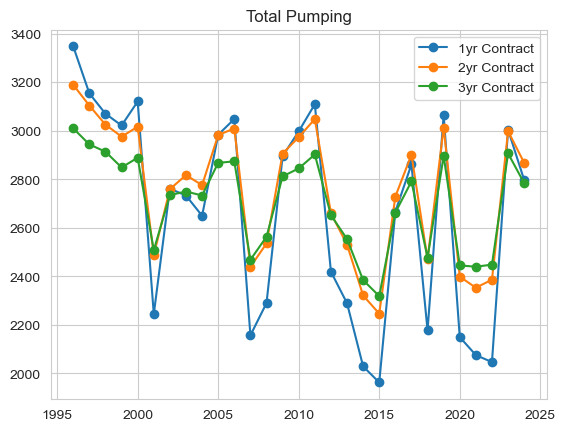

In [47]:
average_revenue_3y = revenue_3y.groupby(['Year','GroupNumber'])['Total Pumping'].mean()
average_revenue_3y = average_revenue_3y.reset_index()
filtered_1y = average_revenue_3y[average_revenue_3y['GroupNumber'] == 1]
filtered_2y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2)]
filtered_2y = filtered_2y.groupby(['Year']).mean().reset_index()
filtered_3y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2) | (average_revenue_3y['GroupNumber'] == 3)]
filtered_3y = filtered_3y.groupby(['Year']).mean().reset_index()
plt.plot(filtered_1y['Year'], filtered_1y['Total Pumping'], label = '1yr Contract', marker='o')
plt.plot(filtered_2y['Year'], filtered_2y['Total Pumping'], label = '2yr Contract', marker='o')
plt.plot(filtered_3y['Year'], filtered_3y['Total Pumping'], label = '3yr Contract', marker='o')
plt.legend()
plt.title('Total Pumping')

# autocorrelation time-series

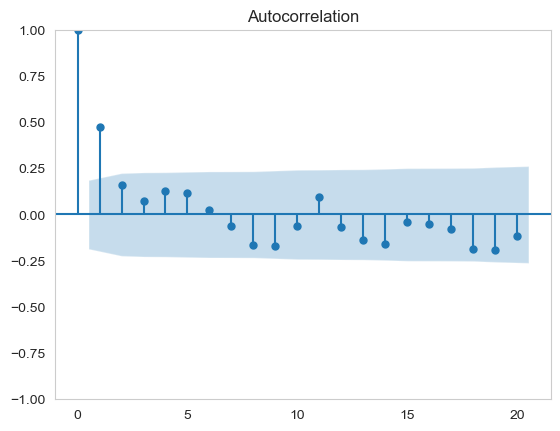

In [30]:
from matplotlib import pyplot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#tranform to standard normal
yearly_pump_data_losthills_nd = (yearly_pump_data_losthills - yearly_pump_data_losthills.mean()) / yearly_pump_data_losthills.std()
plot_acf(yearly_pump_data_losthills_nd, lags=20)
plt.grid(False)
pyplot.show()

In [13]:
print('strike_90', strike_90, 'strike_80', strike_80, 'strike_70', strike_70)

strike_90 2505.646262949155 strike_80 2227.2411226214713 strike_70 1948.835982293787
